**Выполнил:**

Кондрашов Даниил

Магистратура 1 курс ИННОД

- [X] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [X] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [X] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [X] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [X] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [X] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [X] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [X] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [X] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [X] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.


# Импорт библиотек

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


# Первый датасет

## Загрузка

In [344]:
data = pd.read_csv('heart.csv')

## Беглый осмотр датасета

In [345]:
data.sample(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1006,58,1,2,140,211,1,0,165,0,0.0,2,0,2,1
956,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
468,61,1,2,150,243,1,1,137,1,1.0,1,0,2,1


Описание признаков:
- age - возраст в годах
- sex - пол (1 - мужчина, 0 - женщина)
- cp - тип боли в груди
- trestbps - артериальное давление в состоянии покоя (мм рт столба)
- chol - уровень холестерина в сыворотке крови в мг/дл
- fbs - уровень сахара в крови натощак (> 120 мг/дл - 1, <= 120 - 0)
- restecg - результаты электрокардиографии в состоянии покоя. Показывает наличие аномалий в электрической активности сердца в покое.
- thalach - максимальная достигнутая частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой (1 - да, 0 - нет)
- oldpeak - насколько сегмент ST ЭКГ опускается (депрессия) при физической нагрузке по сравнению с состоянием покоя (это прямой признак ишемии миокарда). Чем выше значение, тем больше вероятность ишемии и, следовательно, болезни сердца.
- slope - наклон сегмента ST пикового упражения. Отражает реакцию сердца на нагрузку.
- ca - количество крупных сосудов (0-3) окрашенных методом флуороскопии. Результат коронарной ангиографии, показывает насколько сужены артерии.
- thal - 3 = нормальный, 6 = исправленный дефект, 7 = устраняемый дефект. Показывает кровоснобжение сердечной мышцы.
- target - наличие заболевания (1 = да, 0 = нет)

Нужно решить задачу классификации (предсказание есть заболевание или нет), признак `target`.

Посмотрим на распределение классов целевой переменной.

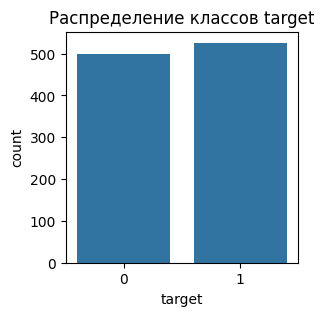

In [346]:
plt.figure(figsize=(3, 3))
sns.countplot(data=data, x='target')
plt.title('Распределение классов target')
plt.show()

Выборка неплохо сбалансирована по классам целевой переменной, можно об этом не беспокоиться.

## EDA

**Для начала посмотрим на типы данных в столбцах и наличие пропусков в них.**

In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [348]:
data.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


Вроде пропусков нет, разве что где-то затесались скрытые.



**Теперь определим какие у нас признаки являются категориальмы, а какие нет + распишем, для какиех категориальных признаков надопровести кодеровку.**

In [349]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
num_cols = ['age', 'trestbps', 'chol', 'oldpeak', 'ca']

In [350]:
data[cat_cols].nunique()

,0
sex,2
cp,4
fbs,2
restecg,3
exang,2
slope,3
thal,4


Видно, что кодировать признаки `sex`, `exang` и `fbs` не нужно, а вот признаки `cp`, `restecg`, `slope` и `thal` придётся обработать. Но делать это мы будем после того, как посмотрим на корреляцию с целевой переменной.

**Теперь посмотрми с какими признаками коррелирует целевая переменная.**

/tmp/ipython-input-3903621678.py:10: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


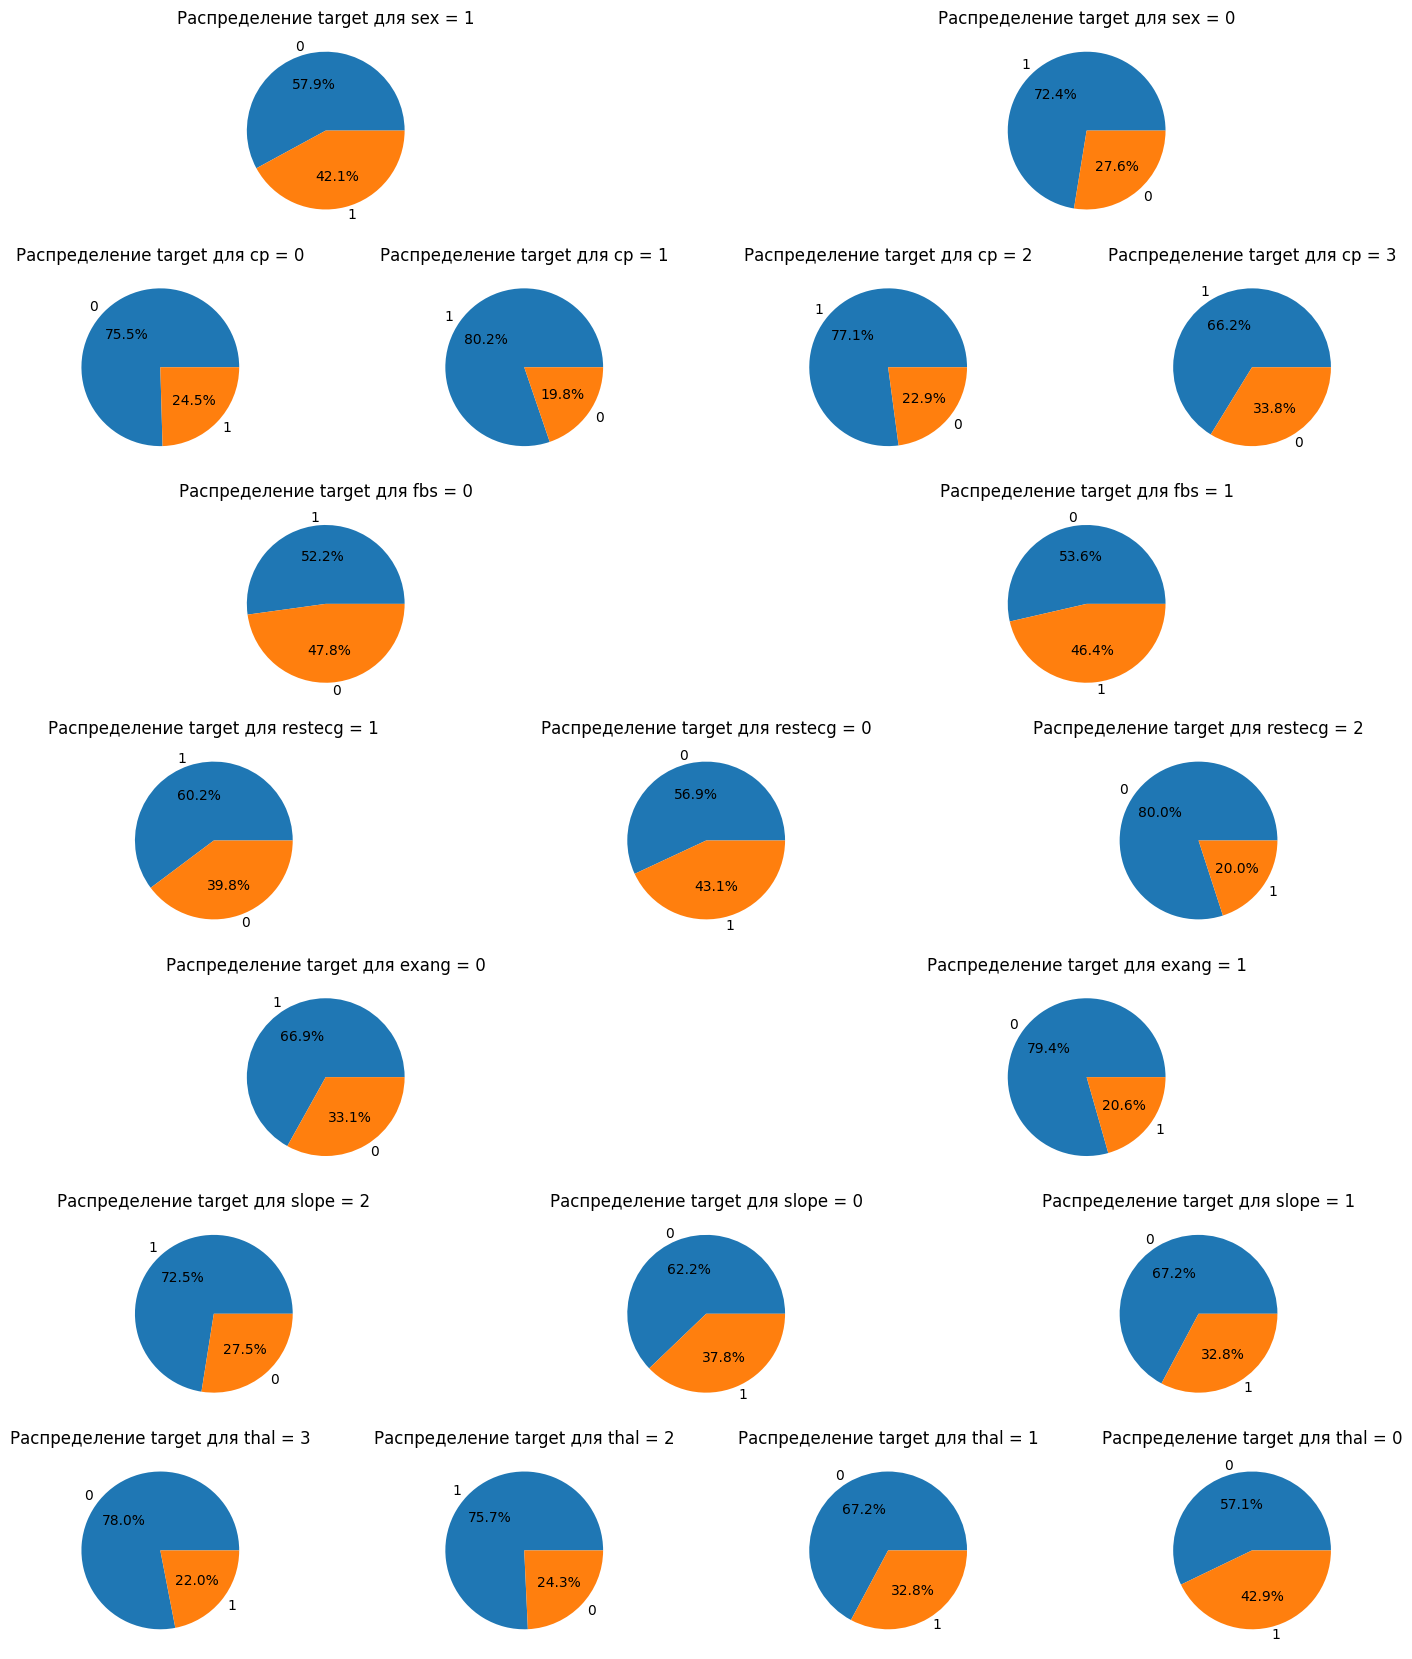

In [351]:
plt.figure(figsize=(18, 21))

for i, col in enumerate(cat_cols):
    for j, val in enumerate(data[col].unique()):
        plt.subplot(7, data[col].nunique(), (i * data[col].nunique()) + j + 1)
        temp = data.loc[data[col] == val, 'target'].value_counts().reset_index()
        plt.pie(x=temp['count'], labels=temp['target'], autopct='%1.1f%%')
        plt.title(f'Распределение target для {col} = {val}')

plt.tight_layout()
plt.show()

**Выводы по графикам:**
- sex:

Видно, что у женщин заболевание сердца процентов на 25-30 наступают реже, чем у мужчин.
- cp:

В этом признаке какой-то значительной корреляции, если честно, нет с целевой переменной. Хотя некоторые типы болей в груди, действительно, чаще свидетельствуют о наличии заболевания сердца.

- fbs:

Тут вообще никакой корреляции нет, стоит удалить признак.

- restecg:

Результаты ЭКГ, как видно из графиков имеют значительную корреляцию. Для значения 2 количество людей с заболеванием в два раза меньше, чем с другими значениями.

- exang:

Тут тоже есть не плохая корреляция.

- slope:

Тут разница между классами ниже, не супер большие и значимые различия.

- thal:

Тут корреляция весьма значимая - важный признак.

Таким образом из категориальных столбцов из бесполезных только признак `fbs`. Наиболее значимыми и полезными являются: `sex`, `restecg`, `exang`, `thal`

**Теперь посмотрим на корреляцию с целевой переменной и выбросы у количественных признаков.**

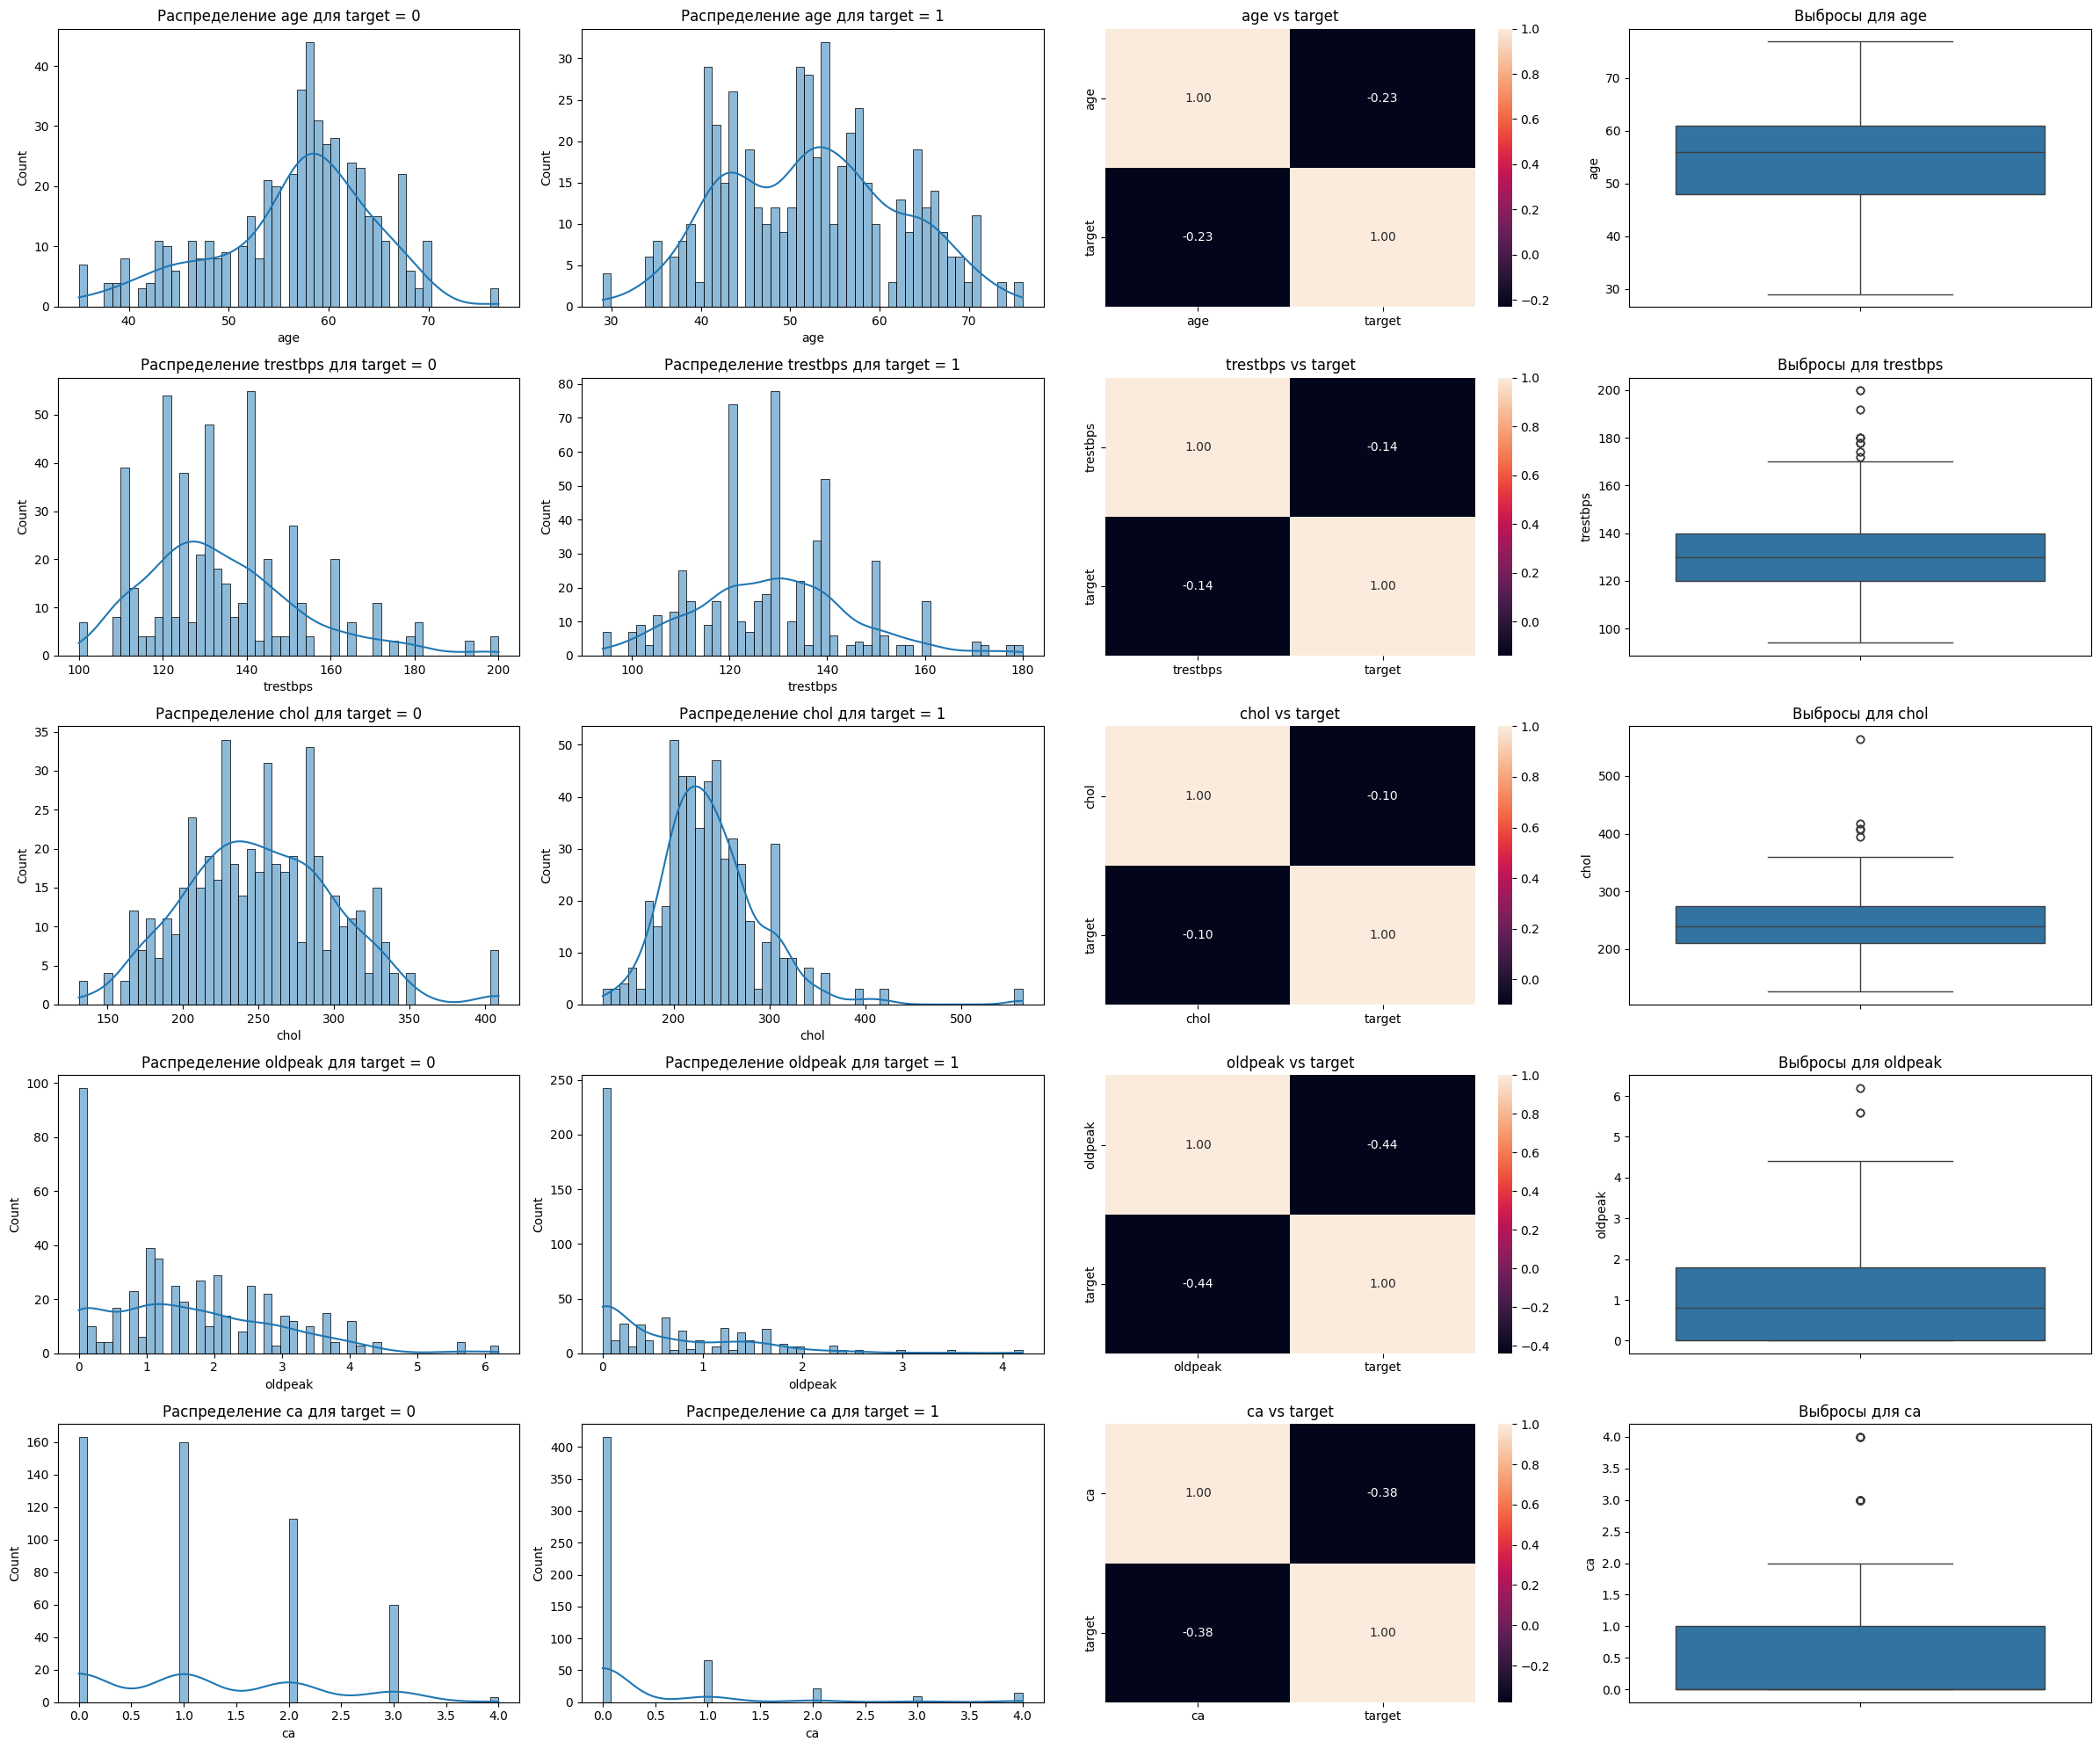

In [352]:
plt.figure(figsize=(24, 20))

for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i * 4 + 1)
    sns.histplot(data=data.query('target == 0'), x=col, kde=True, bins=50)
    plt.title(f'Распределение {col} для target = 0')

    plt.subplot(5, 4, i * 4 + 2)
    sns.histplot(data=data.query('target == 1'), x=col, kde=True, bins=50)
    plt.title(f'Распределение {col} для target = 1')

    plt.subplot(5, 4, i * 4 + 3)
    sns.heatmap(data=data[[col, 'target']].corr(), annot=True, fmt='.2f')
    plt.title(f'{col} vs target')

    plt.subplot(5, 4, i * 4 + 4)
    sns.boxplot(data=data[col])
    plt.title(f'Выбросы для {col}')

plt.tight_layout()
plt.show()

**Выводы по графикам:**
- age:

Честно говря, по графику особо ничего не понятно, почему-то вообще для target = 0 распределение смещено в правую сторону, что, не очень то ожидаемо. Кроме того для target = 1 всё вообще размазано по всем возрастам, что какой-то значимой корреляции не даёт, хотя матрица корреляции утрверждает обратное.

- trestbps:

Несмотря на логическую значимость, какой-то значимой корреляции тут не наблюдается.

- chol:

Снова тут корреляция не очень, хотя, вроде, достаточно важный признак. Некоторая разница в распределениях есть, но она не супер значительная.

- oldpeak:

Тут корреляция значительная, чем больше значение, тем меньше риск заболевания.

- ca:

Тут тоже не маленькая корреляция.

Можно сказать, что слабыми представителями являются признаки `age`, `trestbps` и `chol`, а сильными представителями `oldpeak` и `ca`.

## Обработка признаков

Теперь разделим выборку на тестовую и обучающую части, потом закодируем категориальные признаки и проведём масштабирование количественных признаков.

In [353]:
X = data.drop(columns='target')
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [354]:
def decode_cat_cols(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy(deep=True)

    cp_features = pd.get_dummies(data=data['cp'], prefix='cp', drop_first=True)
    data = pd.concat([data, cp_features], axis=1)

    restecg_features = pd.get_dummies(data=data['restecg'], prefix='restecg', drop_first=True)
    data = pd.concat([data, restecg_features], axis=1)

    slope_features = pd.get_dummies(data=data['slope'], prefix='slope', drop_first=True)
    data = pd.concat([data, slope_features], axis=1)

    thal_features = pd.get_dummies(data=data['thal'], prefix='thal', drop_first=True)
    data = pd.concat([data, thal_features], axis=1)

    data.drop(columns=['cp', 'restecg', 'slope', 'thal'], inplace=True)

    return data

In [355]:
X_train = decode_cat_cols(X_train)
X_test = decode_cat_cols(X_test)

X_train = X_train.drop(columns=['age', 'fbs'])
X_test = X_test.drop(columns=['age', 'fbs'])

rb_scaler = RobustScaler()
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Реализация моделей классификации

### Реализация KNN

In [356]:
class KNNClassifier:
    def __init__(
        self,
        number_of_neighbors: int
    ):
        # задаём количество соседей
        self.k = number_of_neighbors

    def __distance_between_two_objects__(
        self,
        x1: np.ndarray,
        x2: np.ndarray
    ) -> float:

        return np.sqrt(np.sum((x1 - x2) ** 2))

    def __get_distance__(
        self,
        X: np.ndarray,
        start_base: int
    ) -> np.ndarray:
        # вычисляем количество объектов
        n = X.shape[0]
        # инициализируем матрицу расстояний
        # start_base - это для того, чтобы считать расстояния только для новых объектов
        # для которых нужно вычислить предсказания
        # n - start_base - это потому что расстояние мы вычисляем только
        # от новых объектов до старых (между новыми не вычисляем, так как у них нет классов)
        dist_matrix = np.zeros((start_base, n - start_base))

        # считаем расстояния
        for i in range(start_base):
            for j in range(start_base, n):
                dist_matrix[i, j-start_base] = self.__distance_between_two_objects__(x1=X[i], x2=X[j])

        # возвращаем результат
        return dist_matrix

    def __get_k_nearest_neighbors_indices__(
        self,
        dist_matrix: np.ndarray,
        k: int,
        start_base: int
    ) -> np.ndarray:
        # сортируем индексы соседей по убыванию расстояний
        nearest_neighbors_indices = np.argsort(dist_matrix, axis=1)

        # получаем индексы ближайших соседей
        k_nearest_neighbors_indices = nearest_neighbors_indices[:, :k]

        # возвращаем результат
        return k_nearest_neighbors_indices

    def __get_k_nearest_neighbors_classes__(
        self,
        k_nearest_neighbors_indices: np.ndarray,
        y: np.ndarray,
        start_base: int
    ):
        # получаем классы для каждого из соседей
        k_nearest_neighbors_classes =\
            y[k_nearest_neighbors_indices]

        # выбираем для каждого наиболее часто встречающийся класс
        most_common, _ = mode(k_nearest_neighbors_classes, axis=1)

        # возвращаем предсказанные классы
        return most_common.flatten()

    def fit(self,
        X: np.ndarray,
        y: np.ndarray
    ) -> None:
        # запоминаем выборку
        self.X = X.copy()
        self.y = y.copy()

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        # копируем выборку
        X = X.copy()

        # вычисляем количество объектов, для которых будем
        # считать предсказания
        start_base = X.shape[0]

        # конкатенируем с обучающей выборкой (на основе которой предсказываем)
        X = np.vstack([X, self.X])

        # считаем матрицу расстояний
        dist_matrix = self.__get_distance__(X=X, start_base=start_base)

        # считаем индексы ближайших соседей
        k_nearest_neighbors_indices =\
            self.__get_k_nearest_neighbors_indices__(
                dist_matrix=dist_matrix,
                k=self.k,
                start_base=start_base
            )

        # вычисляем предсказания
        predictions =\
            self.__get_k_nearest_neighbors_classes__(
                k_nearest_neighbors_indices=k_nearest_neighbors_indices,
                y=self.y,
                start_base=start_base
            )

        # возвращаем предсказания
        return predictions

### Реализация Binary LogisticRegressionClissifier

In [357]:
class LogisticRegressionBinaryClassifier:
    def __init__(self):
        self.w = None

    def __calc_gradient__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        M: np.ndarray,
        reg: str,
        reg_rate: float,
        batch_size: int
    ) -> np.ndarray:
        grad = (-X.T @ (y / (1 + np.exp(y * M)))) / batch_size

        if reg:
            w_grad = self.w.copy()
            w_grad[-1] = 0

            if reg == 'l1':
                grad += reg_rate * np.sign(w_grad)
            elif reg == 'l2':
                grad += reg_rate * 2 * w_grad

        return grad

    def __calc_M__(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        M = X @ self.w

        return M

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        max_iter: int = 10,
        batch_size: int = 10,
        learning_rate: float = 0.01,
        reg: str = None,
        reg_rate: float = 0.0
    ) -> None:
        X = X.copy()
        y = y.copy()

        y = y.reshape(-1, 1)
        n_samples, n_features = X.shape

        X_train = np.hstack((X, np.ones((n_samples, 1))))

        self.w = np.random.randn(n_features + 1, 1) * 0.01

        self.losses = []

        for _ in range(max_iter):
            random_indices = np.random.choice(len(X_train), size=batch_size, replace=False)

            M = self.__calc_M__(X=X_train[random_indices])

            self.losses.append(accuracy_score(y[random_indices], np.where(M >= 0, 1, -1)))

            grad = self.__calc_gradient__(
                X=X_train[random_indices],
                y=y[random_indices],
                M=M,
                reg=reg,
                reg_rate=reg_rate,
                batch_size=batch_size
            )

            self.w -= learning_rate * grad

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X)

        predictions = np.where(M >= 0, 1, -1)

        return predictions

    def get_weights(self):
        return self.w.copy().flatten()

    def get_losses(self):
        return self.losses.copy()

### Реализация Multy LogisticRegressionClassifier

In [358]:
class LogisticRegressionManyClassifier:
    def __init__(self):
        self.w = None

    def __to_one_hot__(
        self,
        y: np.ndarray,
        n_classes: int
    ) -> np.ndarray:
        n_samples = y.shape[0]

        Y_one_hot = np.zeros((n_samples, n_classes))
        Y_one_hot[np.arange(n_samples), y] = 1

        return Y_one_hot

    def __calc_gradient__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        P: np.ndarray,
        reg: str,
        reg_rate: float,
        n_classes: int,
        batch_size: isinstance
    ) -> np.ndarray:
        Y_one_hot = self.__to_one_hot__(
            y=y,
            n_classes=n_classes
        )

        grad = (X.T @ (P - Y_one_hot)) / batch_size

        if reg:
            w_grad = self.w.copy()
            w_grad[-1, :] = 0

            if reg == 'l1':
                grad += reg_rate * np.sign(w_grad)
            elif reg == 'l2':
                grad += reg_rate * 2 * w_grad

        return grad

    def __calc_M__(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        M = X @ self.w

        return M

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        max_iter: int = 10,
        batch_size: int = 10,
        learning_rate: float = 0.01,
        reg: str = None,
        reg_rate: float = 0.0
    ) -> None:
        X = X.copy()
        y = y.copy()

        n_classes = np.unique(y).shape[0]
        y = y.reshape(-1, 1)
        n_samples, n_features = X.shape


        X_train = np.hstack((X, np.ones((n_samples, 1))))

        self.w = np.random.randn(n_features + 1, n_classes)

        self.losses = []

        for _ in range(max_iter):
            random_indices = np.random.choice(len(X_train), size=batch_size, replace=False)

            M = self.__calc_M__(X=X_train[random_indices])
            P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)

            predictions = np.argmax(P, axis=1)

            self.losses.append(accuracy_score(y[random_indices], predictions))

            grad = self.__calc_gradient__(
                X=X_train[random_indices],
                y=y[random_indices],
                P=P,
                reg=reg,
                reg_rate=reg_rate,
                n_classes=n_classes,
                batch_size=batch_size
            )

            self.w -= learning_rate * grad

    def predict_proba(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X=X)
        M = M - np.max(M, axis=1, keepdims=True)
        P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)

        return P

    def predict(
        self,
        X: np.ndarray
    ) -> np.ndarray:
        n_samples = X.shape[0]

        X = np.hstack((X, np.ones((n_samples, 1))))

        M = self.__calc_M__(X=X)
        M = M - np.max(M, axis=1, keepdims=True)
        P = np.exp(M) / np.sum(np.exp(M), axis=1, keepdims=True)

        predictions = np.argmax(P, axis=1)

        return predictions

    def get_weights(self):
        return self.w.copy()

    def get_losses(self):
        return self.losses.copy()

## Обучение моделей

**Сначала ещё при помощи l1 регуляризации сделаем дополнительный отбор признаков.**

In [359]:
sk_logreg = LogisticRegression(penalty="l1", C=1.0, max_iter=50, solver='liblinear')
my_logreg = LogisticRegressionBinaryClassifier()

sk_logreg.fit(X_train, y_train)
my_logreg.fit(X=X_train, y=y_train, reg='l1', reg_rate=0.01, learning_rate=0.1, max_iter=1000, batch_size=400)

print('sklearn_weights: ')
print(sk_logreg.coef_)
print('my_weights')
print(my_logreg.get_weights())

sklearn_weights: 
[[-1.50171588 -0.27548276 -0.53618973  0.71608157 -0.65733708 -0.92316669
  -0.82359438  1.18519401  1.69143728  2.02439285  0.31124968  0.
  -0.54636457  0.32905832  0.13808693  0.         -1.37544046]]
my_weights
[-1.15292639e-01 -5.02386696e-04  7.46746666e-04  6.22652632e-04
  1.09035505e-03 -9.38079378e-04  7.89650042e-04  3.25784702e-04
  5.37198108e-02  1.70782435e-04  3.67248487e-01  4.85918677e-04
  1.07441086e-01  6.25401136e-01 -5.43178481e-04 -5.10452846e-04
  2.36947747e-04  2.98556264e+00]


Видно, что наименьшее значение для предсказания имели признаки `age`, `fbs`, `restecg_2`, `thal_2`.

Удалим признаки `age`, `fbs`, а остальные 2 трогать не будем, так как они входят в другие признаки.

Кстати сделаю я это выше в коде.

**Теперь обучим и подберём гиперпараметры для логистической регресии.**

In [360]:
logreg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.001, 1.0, 0.01),
    'max_iter': [50, 100, 200, 300, 400],
    'solver': ['liblinear']
}

sk_logreg = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_logreg.fit(X_train, y_train)
sk_logreg.best_params_

{'C': np.float64(0.4109999999999999),
 'max_iter': 50,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [361]:
my_logreg = LogisticRegressionBinaryClassifier()
my_logreg.fit(X=X_train, y=y_train, learning_rate=0.41, reg='l2', reg_rate=0.0001, max_iter=50, batch_size=500)

Качество

In [362]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_logreg.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_logreg.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_logreg.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_logreg.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_logreg.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_logreg.predict(X_test))}')
print("____________________________________________")

print('Качество на обучении для моей реализации')
print(f'accuracy = {accuracy_score(y_train, my_logreg.predict(X_train))}')
print(f'precision = {precision_score(y_train, my_logreg.predict(X_train))}')
print(f'recall = {recall_score(y_train, my_logreg.predict(X_train))}')
print()
print('Качество на тесте для моей реализации')
print(f'accuracy = {accuracy_score(y_test, my_logreg.predict(X_test))}')
print(f'precision = {precision_score(y_test, my_logreg.predict(X_test))}')
print(f'recall = {recall_score(y_test, my_logreg.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8829268292682927
precision = 0.8707482993197279
recall = 0.9078014184397163

Качество на тесте для sklearn реализации
accuracy = 0.8195121951219512
precision = 0.7844827586206896
recall = 0.883495145631068
____________________________________________
Качество на обучении для моей реализации
accuracy = 0.5158536585365854
precision = 0.5158536585365854
recall = 1.0

Качество на тесте для моей реализации
accuracy = 0.5024390243902439
precision = 0.5024390243902439
recall = 1.0
____________________________________________


**Теперь обучим и подберём гиперпараметры KNN**

In [363]:
sk_knn_params = {
    'n_neighbors': [4, 6, 10],
    'metric': ['manhattan', 'euclidean']
}

sk_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=sk_knn_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_knn.fit(X_train, y_train)
sk_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 4}

In [364]:
my_knn = KNNClassifier(number_of_neighbors=4)
my_knn.fit(X=X_train, y=y_train, )

Качество

In [365]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_knn.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_knn.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_knn.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_knn.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_knn.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_knn.predict(X_test))}')
print("____________________________________________")

print('Качество на обучении для моей реализации')
print(f'accuracy = {accuracy_score(y_train, my_knn.predict(X_train))}')
print(f'precision = {precision_score(y_train, my_knn.predict(X_train))}')
print(f'recall = {recall_score(y_train, my_knn.predict(X_train))}')
print()
print('Качество на тесте для моей реализации')
print(f'accuracy = {accuracy_score(y_test, my_knn.predict(X_test))}')
print(f'precision = {precision_score(y_test, my_knn.predict(X_test))}')
print(f'recall = {recall_score(y_test, my_knn.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.9621951219512195
precision = 0.992462311557789
recall = 0.933806146572104

Качество на тесте для sklearn реализации
accuracy = 0.8634146341463415
precision = 0.9120879120879121
recall = 0.8058252427184466
____________________________________________
Качество на обучении для моей реализации
accuracy = 0.9621951219512195
precision = 0.992462311557789
recall = 0.933806146572104

Качество на тесте для моей реализации
accuracy = 0.8634146341463415
precision = 0.9120879120879121
recall = 0.8058252427184466
____________________________________________


**Теперь обучим и подберём параметры для метода опорных векторов.**

In [366]:
sk_svm_params = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1]
}

sk_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=sk_svm_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_svm.fit(X_train, y_train)
sk_svm.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

Качество

In [367]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_svm.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_svm.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_svm.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_svm.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_svm.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_svm.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8768292682926829
precision = 0.8744186046511628
recall = 0.8888888888888888

Качество на тесте для sklearn реализации
accuracy = 0.824390243902439
precision = 0.7863247863247863
recall = 0.8932038834951457
____________________________________________


**Теперь обучим и подберём гиперпараметры для наивного байесовского классификатора.**

In [368]:
sk_bc_params = {
    'priors': [None, 0.3, 0.7],
    'var_smoothing': [0, 0.5, 1.0, 1.5]
}

sk_bc = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=sk_bc_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_bc.fit(X_train, y_train)
sk_bc.best_params_

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

{'priors': None, 'var_smoothing': 0}

Качество

In [369]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_bc.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_bc.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_bc.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_bc.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_bc.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_bc.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8548780487804878
precision = 0.8438914027149321
recall = 0.8817966903073287

Качество на тесте для sklearn реализации
accuracy = 0.824390243902439
precision = 0.7863247863247863
recall = 0.8932038834951457
____________________________________________


**Теперь обучим и подберём параметры для решающего дерева.**

In [370]:
sk_tree_params = {
    'max_depth': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 10, 16],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

sk_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=sk_tree_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_tree.fit(X_train, y_train)
sk_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Качество

In [371]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_tree.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_tree.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_tree.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_tree.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_tree.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_tree.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.9817073170731707
precision = 0.9788732394366197
recall = 0.9858156028368794

Качество на тесте для sklearn реализации
accuracy = 0.9658536585365853
precision = 0.9615384615384616
recall = 0.970873786407767
____________________________________________


**Теперь построим матрицы ошибок.**

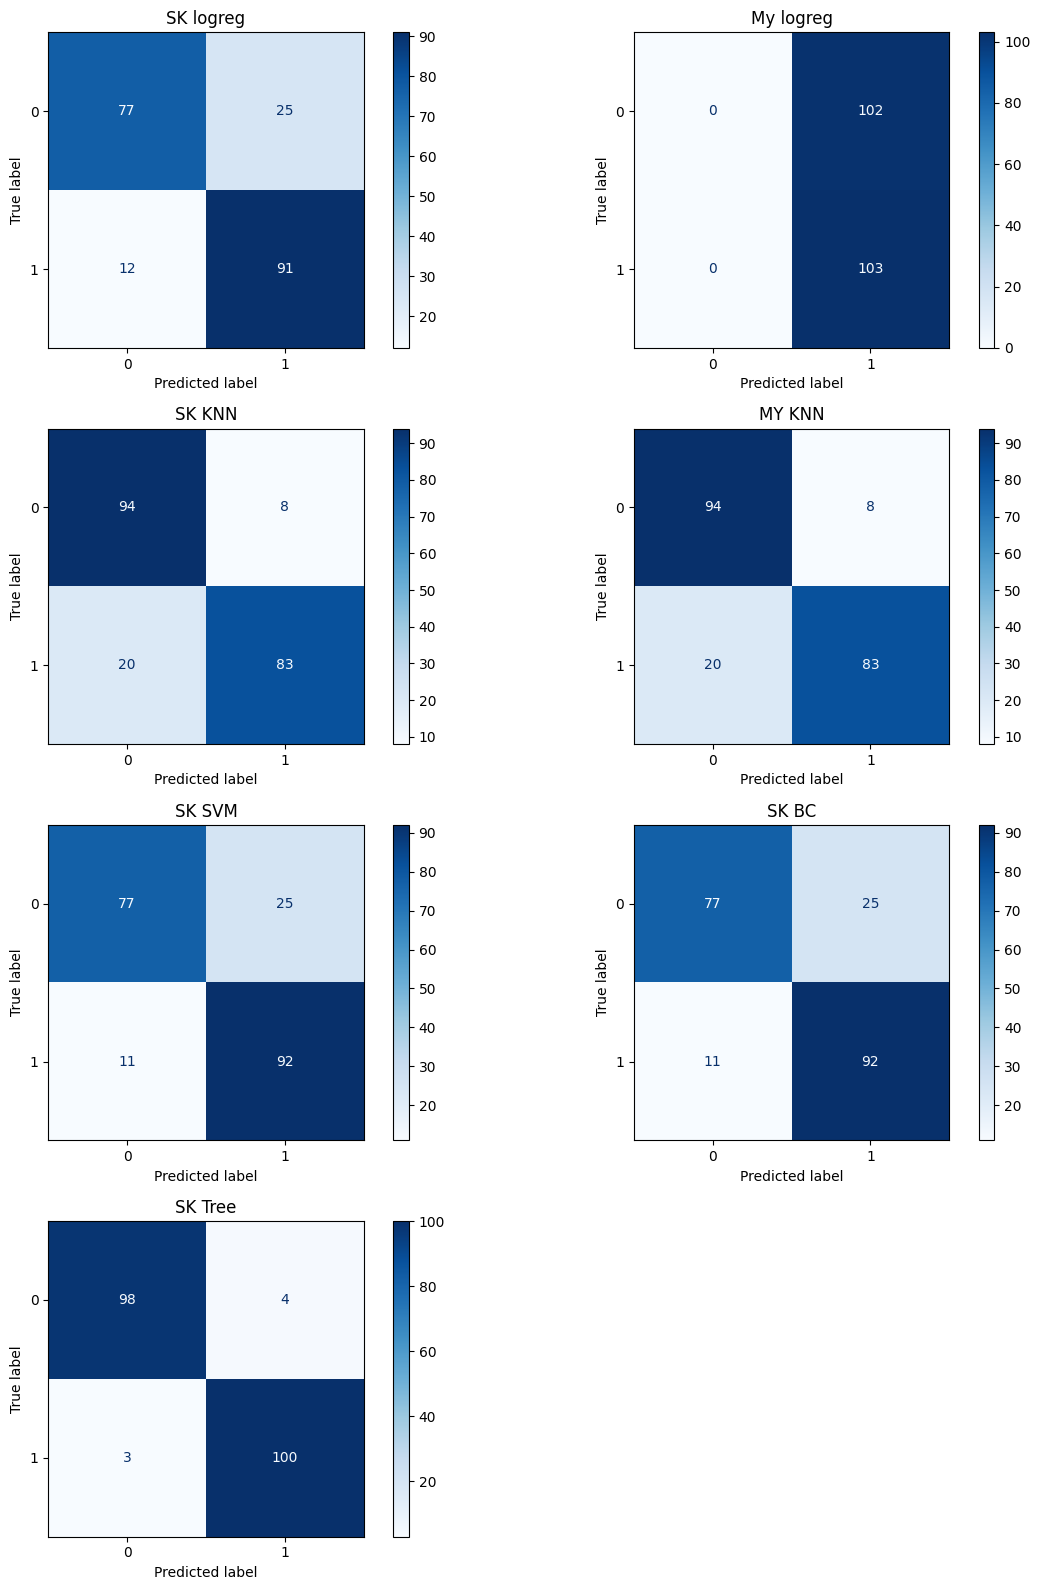

In [372]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.ravel()  # Преобразуем в плоский массив

models = [
    ('SK logreg', sk_logreg),
    ('My logreg', my_logreg),
    ('SK KNN', sk_knn),
    ('MY KNN', my_knn),
    ('SK SVM', sk_svm),
    ('SK BC', sk_bc),
    ('SK Tree', sk_tree)
]

for i, (title, model) in enumerate(models):
    ax = axes[i]
    ax.set_title(title)
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data['target'].unique())
    disp.plot(ax=ax, cmap='Blues')

# Скрываем последнюю пустую subplot если моделей 7, а subplots 8
if len(models) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

Можно сказать, что logreg у меня получился не очень, видимо где-то происходят переполнения + возможно не эффективная какая-то реализация. KNN получился достаточно хорошо, качество аналогичное реализации SkLearn.

Лучше всего себя проявили нелинейные модели KNN и DTC, DTC вообще работает практически идеально. Вероятно это так, так как зависимость целевой переменной от признаков нелинейная.

# Второй датасет

## Загрузка данных и их краткое описание

In [373]:
!gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
!gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset

Downloading...
From: https://drive.google.com/uc?id=1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3
To: /content/game_of_thrones_test.csv
100% 37.3k/37.3k [00:00<00:00, 48.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v
To: /content/game_of_thrones_train.csv
100% 138k/138k [00:00<00:00, 5.14MB/s]


In [374]:
data = pd.read_csv("game_of_thrones_train.csv", index_col = "S.No")

Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

## EDA

### Беглый осмотр датасета

Посмотрим на размерность датасета и на то, как выглядят объекты в нём

In [375]:
data.shape

(1557, 25)

In [376]:
data.sample(3)

,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,...,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,
1068,Grazdar zo Galare,Cupbearer,1,Ghiscari,NaN,NaN,NaN,NaN,House of Galare,NaN,...,NaN,NaN,NaN,NaN,0,1,NaN,0,0.010033,1
71,Rainbow Knight,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,0,0.003344,1
820,Old Grey Gull,NaN,1,Ironborn,NaN,NaN,NaN,NaN,Drowned men,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,0,0.010033,1


Посмотрим на типы столбцов

In [377]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1557 entries, 1 to 1557
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1557 non-null   object 
 1   title             717 non-null    object 
 2   male              1557 non-null   int64  
 3   culture           488 non-null    object 
 4   dateOfBirth       279 non-null    float64
 5   mother            18 non-null     object 
 6   father            22 non-null     object 
 7   heir              21 non-null     object 
 8   house             1176 non-null   object 
 9   spouse            200 non-null    object 
 10  book1             1557 non-null   int64  
 11  book2             1557 non-null   int64  
 12  book3             1557 non-null   int64  
 13  book4             1557 non-null   int64  
 14  book5             1557 non-null   int64  
 15  isAliveMother     18 non-null     float64
 16  isAliveFather     22 non-null     float64
 17  

Первично оценим количество пропусков в столбцах

In [378]:
data.isna().sum()

,0
name,0
title,840
male,0
culture,1069
dateOfBirth,1278
mother,1539
father,1535
heir,1536
house,381
spouse,1357


В большом числе столбцов пропусков подавляющее количество. Однако объём датасета не позволяет просто удалить такие признаки. Будем принимать решение о заполнении или удалении по ходу рассмотрения каждого признака.

Посмотрим на распределение целевой переменной.

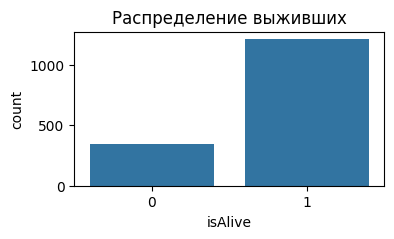

In [379]:
plt.figure(figsize=(4, 2))
sns.countplot(data=data, x='isAlive')
plt.title('Распределение выживших')
plt.show()

Дисбаланс классов есть, стоит попробовать провести балансировку перед обучением.

Также для удобства сразу приведём строковые признаки к нижнему регистру.

In [380]:
for column in data.select_dtypes('object').columns:
    data.loc[:, column] = data.loc[:, column].str.lower()

### Категориальный признак name

In [381]:
data['name'].nunique()

1557

In [382]:
data['name'].values[:10]

array(['viserys ii targaryen', 'walder frey', 'addison hill',
       'aemma arryn', 'sylva santagar', 'tommen baratheon',
       'valarr targaryen', 'viserys i targaryen', 'wilbert',
       'wilbert osgrey'], dtype=object)

Данный признак сам по себе бесполезный, однако, как можно заметить, за именем часто следует название дома или рода, что может помочь в заполнении пропусков в признаке house. Кроме того, в данном поле можно ещё встретить титулы, что также поможет заполнению пропусков.

Таким образом, будем использовать этот признак для подготовки данных, а удалим его уже перед разделением на обучающую и тестовую выборки.

### Порядковый признак title

In [383]:
display(data['title'].nunique()), display(data['title'].value_counts());

194

,count
title,
ser,306
maester,29
archmaester,21
lord,19
septon,16
...,...
lord of hellholt,1
red flower vale,1
lord of harrenhal,1


Несмотря на то, что по логике это должен быть порядковый признак (у титулов есть иерархия), тут слишком много различных сфер деятельности чтоли, для каждой из которых иерархия будет отдельная.

Выхода у тут два:
- выделить какие-то равные по величине титулы и приравнять их;
- принять данный признак за категориальный и не проводить ранжирование.

Первый вариант, наверное, более правильный, однако, есть вероятность, что у высших чинов разных организаций сметрность может быть разной, из-за чего ранжирование может дать корреляцию хуже.

Второй вариант проще и, моежт оказаться даже лучше.

Но для разнообразия будем применять первый вариант.

Однако перед началом стоит заполнить пропуски в данном признаке, а их достаточно много.

Заполнять пропуски можно по имени, так как там иногда указывается титул. Также можно заполнять пропуски исходя из титулов родителей, однако это слишком сложно и делать я это не буду ;)

In [384]:
def fill_missing_titles(name: str) -> str:
    titles = [
        'King', 'Queen', 'Prince', 'Princess', 'Lord', 'Lady', 'Ser', 'Maester',
        'Archmaester', 'Grand Maester', 'Hand', 'Castellan', 'Seneschal', 'Steward',
        'Captain', 'Commander', 'Lord Commander', 'Master', 'Knight', 'Septon', 'Septa',
        'Goodwife', 'Goodman', 'Wisdom', 'Khal', 'Khalakka', 'Bloodrider',
        'Protector', 'Dowager', 'Regent', 'Chancellor'
    ]

    for title in titles:
        if title in name:
            return title

    else:
        return "title no data"

In [385]:
data.loc[data['title'].isna(), 'title'] = data.loc[data['title'].isna(), 'name'].apply(fill_missing_titles)

Теперь проведём ранжирование титулов.

In [386]:
def ranking_of_titles(title: str) -> int:
    title_hierarchy = {
        # Уровень 10 - Верховная власть
        'king': 10, 'queen': 10, 'prince': 10, 'princess': 10,
        'king in the north': 10, 'king-beyond-the-wall': 10,
        'lord paramount of the mander': 10, 'lord paramount of the trident': 10,
        'prince of dorne': 10, 'prince of dragonstone': 10,
        'hand of the king': 10, 'protector of the realm': 10,

        # Уровень 9 - Высшая знать
        'lord': 9, 'lady': 9, 'lord of': 9, 'lady of': 9,
        'lord commander': 9, 'lord reaper of pyke': 9,
        'lord of the iron islands': 9, 'lord of the crossing': 9,
        'lord of the tides': 9, 'lord of the marches': 9,

        # Уровень 8 - Старшая знать
        'castellan': 8, 'master': 8, 'seneschal': 8, 'high steward': 8,
        'lord steward': 8, 'master of': 8, 'lord seneschal': 8,

        # Уровень 7 - Рыцарство и командиры
        'ser': 7, 'commander': 7, 'captain': 7, 'knight': 7,
        'first sword': 7, 'first ranger': 7,

        # Уровень 6 - Религиозные лидеры
        'archmaester': 6, 'grand maester': 6, 'septa': 6, 'septon': 6,
        'red priest': 6, 'blue grace': 6,

        # Уровень 5 - Специалисты
        'maester': 5, 'wisdom': 5, 'steward': 5, 'magister': 5,

        # Уровень 4 - Воины и всадники
        'bloodrider': 4, 'khal': 4, 'khalakka': 4, 'warrior': 4,

        # Уровень 3 - Младшие должности
        'cupbearer': 3, 'brother': 3, 'goodman': 3, 'goodwife': 3,
        'proctor': 3,

        # Уровень 2 - Простые титулы
        'good master': 2, 'tradesman': 2,

        # Уровень 1 - Неопределенные
        'winterfell': 1, 'casterly rock': 1, 'highgarden': 1,
        'rain house': 1, 'eyrie': 1, 'dragonstone': 1,
        'seven kingdoms': 1, 'greenstone': 1, 'stokeworth': 1,
        'hornwood': 1, 'coldmoat': 1, 'last hearth': 1,
        'seagard': 1, 'uplands': 1, 'ashford': 1, 'bitterbridge': 1,
        'whitewalls': 1, 'claw isle': 1, 'ironoaks': 1,
        'goldengrove': 1, 'redfort': 1, 'harridan hill': 1,
        'longbow hall': 1, 'hayford': 1, 'skyreach': 1,
        'feastfires': 1, 'sweetsister': 1, 'starpike': 1,
        'sweetport sound': 1, 'stonehelm': 1, 'greyshield': 1,
        'felwood': 1, 'goldgrass': 1, 'tower of glimmering': 1,
        'big bucket': 1, 'honeyholt': 1, 'runestone': 1,
        'duskendale': 1, 'grassy vale': 1, 'dyre den': 1,
        'sunflower hall': 1, 'pinkmaiden': 1, 'cerwyn': 1,
        'snakewood': 1, 'flint\'s finger': 1, 'longsister': 1,
        'coldwater burn': 1, 'fair isle': 1, 'deepwood motte': 1,
        'acorn hall': 1, 'ten towers': 1, 'saltpans': 1,
        'sealskin point': 1, 'three sisters': 1, 'grey glen': 1,
        'iron holt': 1, 'maidenpool': 1, 'starfall': 1,
        'nightsong': 1, 'eastwatch-by-the-sea': 1,
        'red flower vale': 1, 'hellholt': 1, 'crakehall': 1,
        'the liddle': 1, 'salt shore': 1, 'tally hill': 1,
        'king\'s landing': 1, 'crag': 1, 'volmark': 1,
        'rook\'s rest': 1, 'oldcastle': 1, 'southshield': 1,
        'sandstone': 1, 'wyndhall': 1, 'knight of': 1,
        'lord of atranta': 1, 'lord of oldtown': 1,
        'lord of pebbleton': 1, 'lord of the red dunes': 1,
        'lord of the snakewood': 1, 'lord of the tor': 1,

        # Уровень 0 - Неизвестные и специальные случаи
        'title no data': 0, 'light of the west': 1, 'mistress of whisperers': 1,
        'master of ships': 1, 'master of coin': 1, 'foamdrinker': 1,
        'king of astapor': 10, 'greenstone': 1, 'wind witch': 1,
        'chief undergaoler': 3, 'undergaoler': 3, 'oarmaster': 3,
        'master-at-arms': 3, 'the wull': 2, 'red hand': 2,
        'widow\'s watch': 1, 'castle lychester': 1, 'heart\'s home': 1,
        'godsgrace': 1, 'karl\'s hold': 1, 'blackmont': 1,
        'golden tooth': 1, 'crows nest': 1, 'deep den': 1,
        'sharp point': 1, 'cobblecat': 1, 'three towers': 1,
        'ghost hill': 1, 'shatterstone': 1, 'lordsport': 1,
        'blackcrown': 1, 'strongsong': 1, 'brightwater': 1,
        'broad arch': 1, 'lady marya': 1, 'golden tooth': 1,
        'harrenhal': 1, 'karhold': 1, 'riverrun': 1,
        'king of the andals': 10, 'king of the iron islands': 10,
        'black bride': 1, 'princessqueen': 10, 'queendowager queen': 10,
        'princesssepta': 6, 'lord commander of the night\'s watch': 9
    }

    return title_hierarchy[title] if title in title_hierarchy else 0

In [387]:
data['title'] = data['title'].apply(ranking_of_titles)

Теперь посмотрим на корреляцию с целевой переменной.

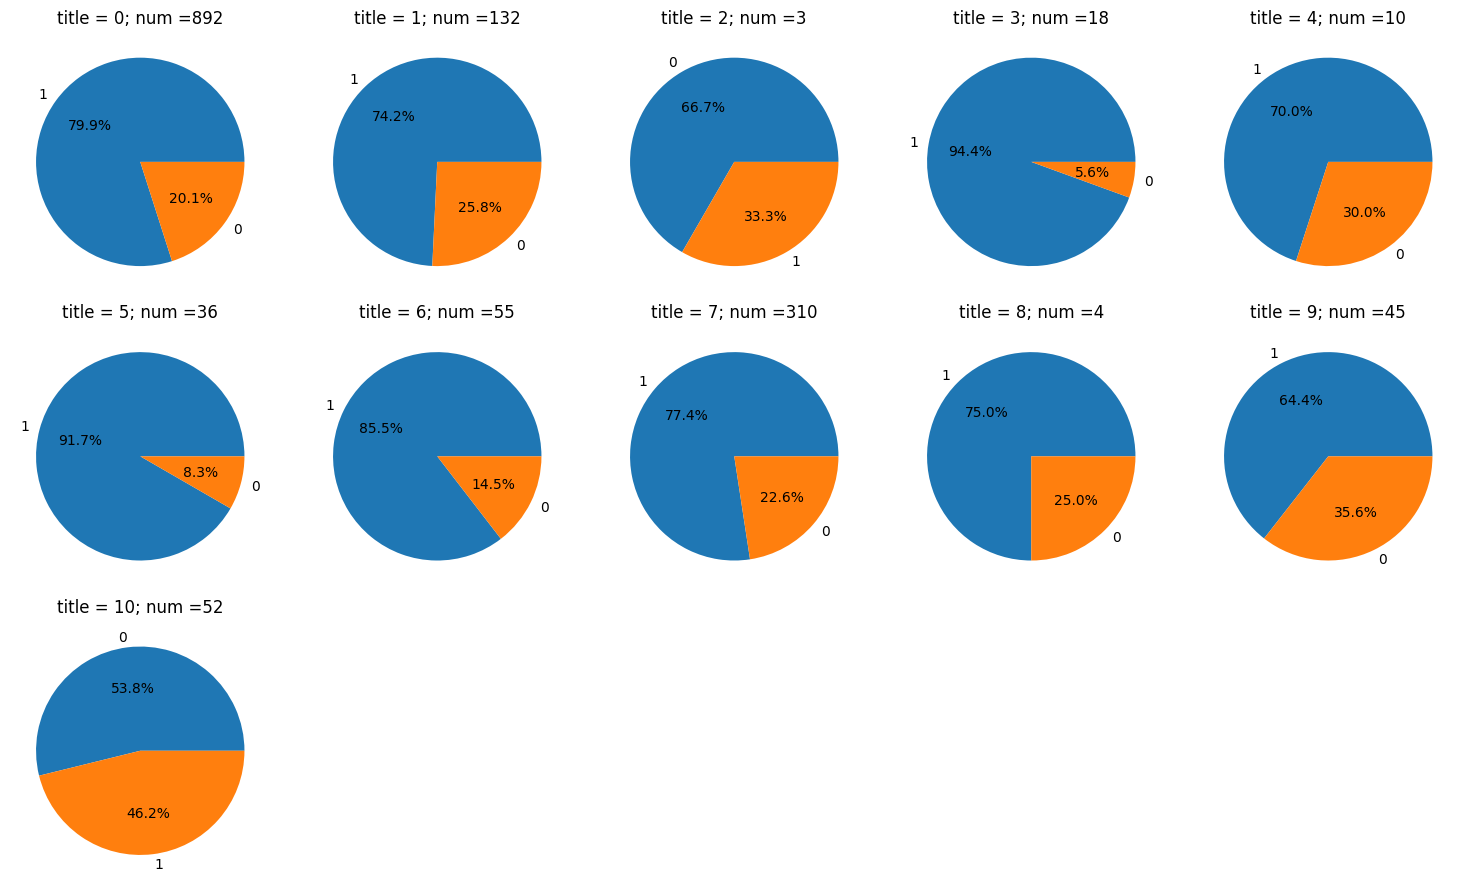

In [388]:
plt.figure(figsize=(15, 9))

for i, title_rank in enumerate(sorted(data['title'].unique())):
    temp = data.loc[data['title'] == title_rank, 'isAlive'].value_counts().reset_index()
    plt.subplot(3, 5, i + 1)
    plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
    plt.title(f"title = {title_rank}; num ={sum(temp['count'])}")

plt.tight_layout()
plt.show()

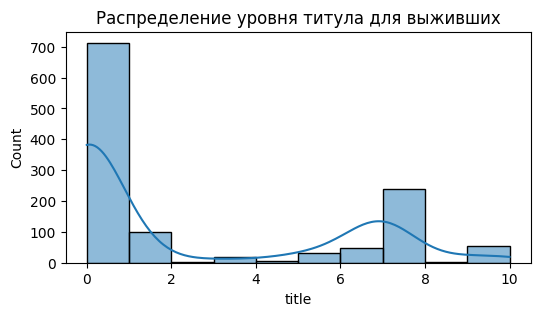

In [389]:
plt.figure(figsize=(6, 3))
sns.histplot(data=data[data['isAlive'] == 1], x='title', kde=True, bins=10)
plt.title('Распределение уровня титула для выживших')
plt.show()

Видно, что зависимость есть, но она явно не линейная, так как есть два пика.

### Категориальный признак male

In [390]:
data['male'].value_counts()

,count
male,
1,920
0,637


С данным признаком всё хорошо, он уже готов к использованию.

Посмотрим на корреляцию с целевой переменной.

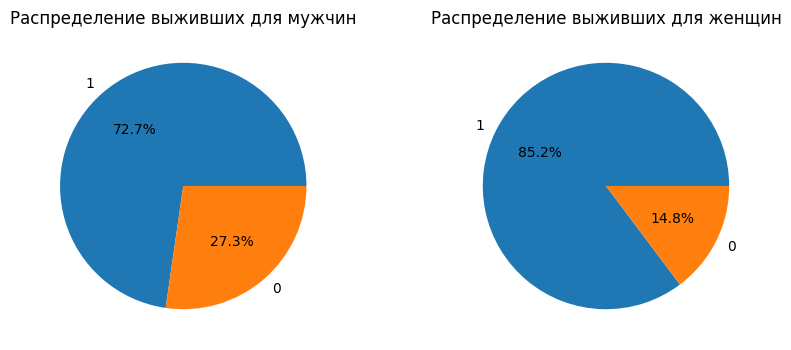

In [391]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
temp = data[data['male'] == 1]['isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title('Распределение выживших для мужчин')

plt.subplot(1, 2, 2)
temp = data[data['male'] == 0]['isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title('Распределение выживших для женщин')

plt.show()

Корреляция с целевой переменной прослеживается, женщины выживают заметно чаще, чем мужчины.

### Категориальный признак culture

Для данного признака будем следовать рекомендациям, которые прописаны в ноутбуке задания.

Укрупняем группы

In [392]:
cultures_grouped = {
    'old nations': ['valyrian', 'first men', 'andal', 'andals', 'rhoynar'],
    'the north': ['northmen', 'northern mountain clans', 'crannogmen'],
    'the iron islands': ['ironborn', 'ironborn', 'ironmen'],
    'the mountain and the vale': ['valemen', 'vale', 'vale mountain clans', 'sistermen'],
    'the isles and rivers': ['riverlands', 'rivermen'],
    'the rock': ['westerman', 'westermen', 'westerlands'],
    'the stormlands': ['stormlander', 'stormlands'],
    'the reach': ['reach', 'reachmen', 'the reach'],
    'dorne': ['dornish', 'dornishmen', 'dorne'],
    'essos nations': ['astapor', 'astapori', 'braavosi', 'braavos', 'tyroshi', 'lysene', 'lyseni',
                    'myrish', 'pentoshi', 'qartheen', 'qarth', 'dothraki',
                    'lhazarene', 'lhazareen', 'meereen', 'meereenese',
                    'norvoshi', 'qohor', 'summer isles', 'summer islands',
                    'summer islander', 'asshai', "asshai'i", 'norvos', 'ghiscari',
                    'ghiscaricari'],
    'other nations': ['ibbenese', 'westeros', 'free folk', 'wildling', 'wildlings', 'naathi']
}

cultures_grouped_inverted = {}
for k in cultures_grouped.keys():
  for v in cultures_grouped[k]:
      cultures_grouped_inverted.update({v:k})

In [393]:
def group_culture(culture: str) -> str:
    return cultures_grouped_inverted[culture] if culture in cultures_grouped_inverted else "other nations"

In [394]:
data.loc[data['culture'].notna(), 'culture'] = data.loc[data['culture'].notna(), 'culture'].apply(group_culture)

В данном столбце очень много пропусков, которые тоже нужно заполнить.

Часть значений можно заполнить по культуре отца или матери, остальные пропуски заменим на unknown_culture.

In [395]:
def fill_missing_culture(row):
    father = row['father']
    mother = row['mother']

    if pd.notna(father) and father in data['name'].values:
        father_culture = data.loc[data['name'] == father, 'culture']
        if not father_culture.empty and pd.notna(father_culture.iloc[0]):
            return father_culture.iloc[0]

    if pd.notna(mother) and mother in data['name'].values:
        mother_culture = data.loc[data['name'] == mother, 'culture']
        if not mother_culture.empty and pd.notna(mother_culture.iloc[0]):
            return mother_culture.iloc[0]

    return "culture no data"

In [396]:
data.loc[data['culture'].isna(), 'culture'] = data.loc[data['culture'].isna(), ['father', 'mother']].apply(fill_missing_culture, axis=1)

Столбце полностью обработан, теперь можно посмотреть на количество уникальных значений и корреляцию с целевой переменной.

In [397]:
data['culture'].value_counts()

,count
culture,
culture no data,1062
essos nations,109
the north,108
the iron islands,95
other nations,57
old nations,36
the mountain and the vale,25
dorne,21
the rock,16


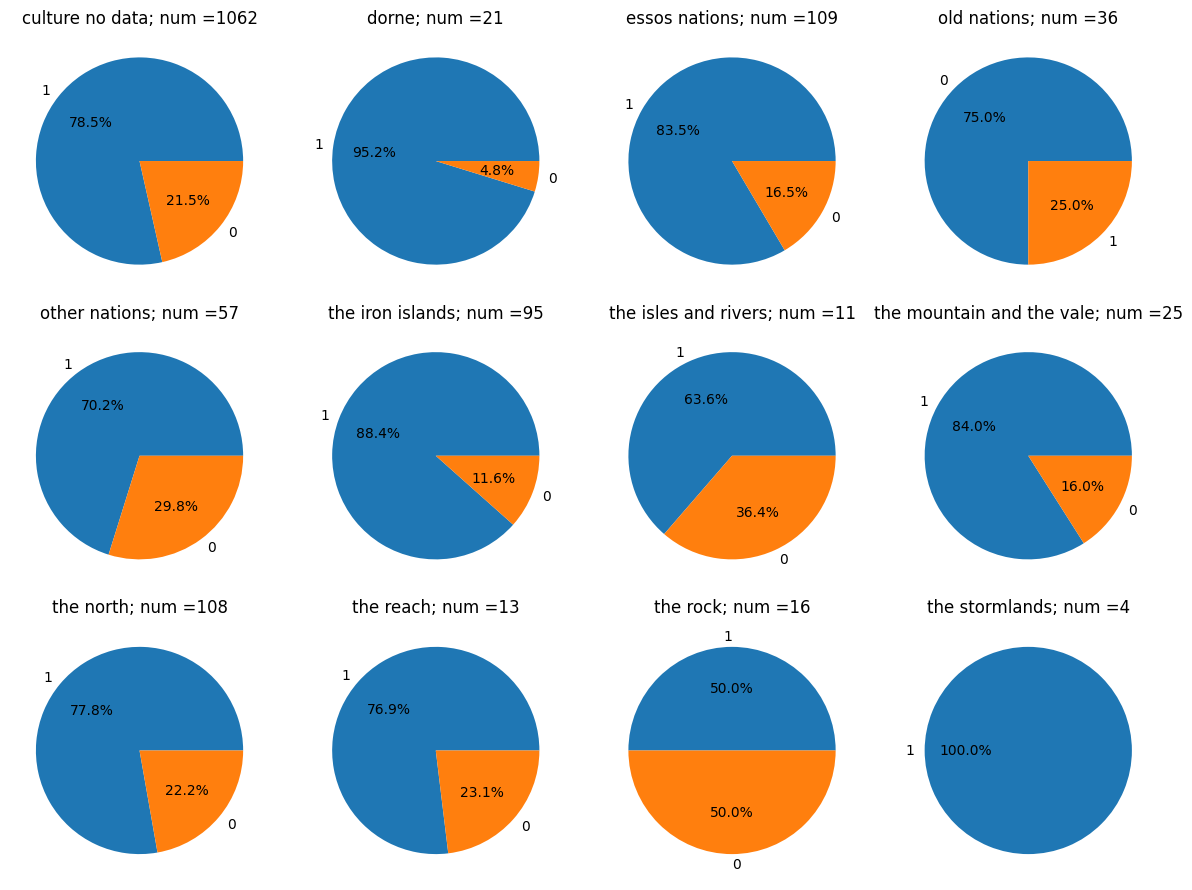

In [398]:
plt.figure(figsize=(12, 9))

for i, culture in enumerate(sorted(data['culture'].unique())):
    temp = data.loc[data['culture'] == culture, 'isAlive'].value_counts().reset_index()
    plt.subplot(3, 4, i + 1)
    plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
    plt.title(f"{culture}; num ={sum(temp['count'])}")

plt.tight_layout()
plt.show()

Можно сказать, что зависимость есть, для некоторых культур процент выживших гораздо больше.

In [399]:
d2 = data.copy(deep=True)

### Признак dateofBirth

Данный признак на мой взгляд точно не нужен, кроме того по нему нельзя заполнить пропуски в age, следовательно, данный признак стоит удалить.

### Категориальный признак mother

По большому счёту данный признак небудет иметь большой корреляции, так как колтичество детей не может быть огромным, а большое количество категорий в итоге приведёт лишь к переобучению.

Поэтому удалим данный признак (но попозже, в конце).

### Категориальный признак father

По большому счёту данный признак небудет иметь большой корреляции, так как колтичество детей не может быть огромным, а большое количество категорий в итоге приведёт лишь к переобучению.

Поэтому удалим данный признак.

### Категориальный признак heir

Опять же тут слишком много пропусков и слишком много имён, поэтому данный признак стоит преобразовать.

Логично будет его преобразовать в категории есть наследник и нет наследника, сделаем это.

In [400]:
data.loc[data['heir'].notna(), 'heir'] = 'have heir'
data.loc[data['heir'].isna(), 'heir'] = 'dont have heir'

In [401]:
data['heir'].value_counts()

,count
heir,
dont have heir,1536
have heir,21


Посмотрим на корреляцию с целевой переменной.

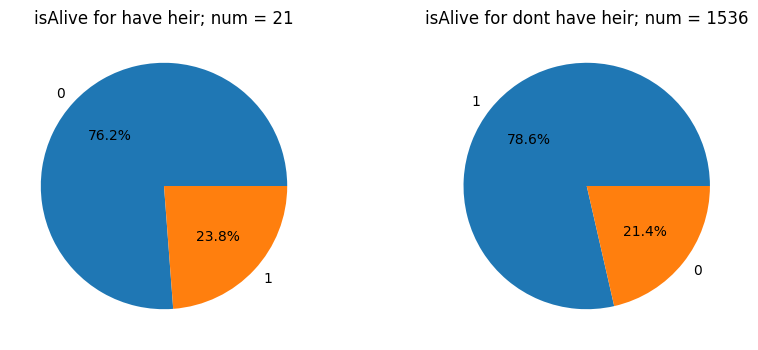

In [402]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
temp = data.loc[data['heir'] == 'have heir', 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'isAlive for have heir; num = {sum(temp['count'])}')

plt.subplot(1, 2, 2)
temp = data.loc[data['heir'] == 'dont have heir', 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'isAlive for dont have heir; num = {sum(temp['count'])}')

plt.show()

В данном случае не просто отсутствует корреляция, но ещё и людей с наследниками очень мало, следовательно, это будет приводить к переобучению. Таким образом, данный столбец стоит удалить.

In [403]:
data = data.rename(columns={'heir': 'have heir data'})

### Категориальный признак house

In [404]:
data['house'].value_counts(dropna=False)

,count
house,
NaN,381
house frey,89
night's watch,88
house stark,56
house targaryen,40
...,...
house longwaters,1
house thorne,1
house moreland,1


В данном признаке есть проблемы как с пропусками, так и с слишком большим количеством категорий.

Сделать нужно следующее:
1) попытаться заполнить пропуски по признаку name;
2) установить попрог в 30 человек;
3) оставить категории, в которых >= порог, а остальные слить в группу rare house.

Заполним пропуски

In [405]:
def fill_missing_house(name: str) -> str:
    house_mapping = {
        # Основные великие дома
        'targaryen': 'House Targaryen', 'stark': 'House Stark',
        'lannister': 'House Lannister', 'baratheon': 'House Baratheon',
        'greyjoy': 'House Greyjoy', 'tyrell': 'House Tyrell',
        'martell': 'House Martell', 'arryn': 'House Arryn',
        'tully': 'House Tully', 'frey': 'House Frey',
        'bolton': 'House Bolton', 'mormont': 'House Mormont',
        'tarly': 'House Tarly', 'reed': 'House Reed',
        'glover': 'House Glover', 'umber': 'House Umber',
        'karstark': 'House Karstark', 'manderly': 'House Manderly',
        'cerwyn': 'House Cerwyn', 'hightower': 'House Hightower',
        'redwyne': 'House Redwyne', 'florent': 'House Florent',
        'harlaw': 'House Harlaw', 'goodbrother': 'House Goodbrother',
        'botley': 'House Botley', 'blacktyde': 'House Blacktyde',
        'drumm': 'House Drumm', 'farwynd': 'House Farwynd',
        'volmark': 'House Volmark', 'wull': 'House Wull',
        'dayne': 'House Dayne', 'yronwood': 'House Yronwood',
        'fowler': 'House Fowler', 'blackwood': 'House Blackwood',
        'bracken': 'House Bracken', 'mallister': 'House Mallister',
        'marbrand': 'House Marbrand', 'crakehall': 'House Crakehall',
        'lefford': 'House Lefford', 'brax': 'House Brax',
        'prester': 'House Prester', 'swyft': 'House Swyft',
        'serrett': 'House Serrett', 'bane': 'House Bane',

        # Другие значимые дома
        'osgrey': 'House Osgrey', 'webber': 'House Webber',
        'costayne': 'House Costayne', 'peake': 'House Peake',
        'ball': 'House Ball', 'caron': 'House Caron',
        'dondarrion': 'House Dondarrion', 'swann': 'House Swann',
        'tarth': 'House Tarth', 'selmy': 'House Selmy',
        'estermont': 'House Estermont', 'velaryon': 'House Velaryon',
        'celtigar': 'House Celtigar', 'santagar': 'House Santagar',
        'allyrion': 'House Allyrion', 'vaith': 'House Vaith',
        'manwoody': 'House Manwoody', 'qorgyle': 'House Qorgyle',
        'jor': 'House Jordayne', 'toland': 'House Toland',
        'blackmont': 'House Blackmont', 'fowler': 'House Fowler',
        'gargalen': 'House Gargalen', 'uller': 'House Uller',
        'wells': 'House Wells', 'stokeworth': 'House Stokeworth',
        'rosby': 'House Rosby', 'rykker': 'House Rykker',
        'thorne': 'House Thorne', 'paege': 'House Paeg',
        'piper': 'House Piper', 'vance': 'House Vance',
        'smallwood': 'House Smallwood', 'mooton': 'House Mooton',
        'dar': 'House Darry', 'ryger': 'House Ryger',
        'goodbrook': 'House Goodbrook', 'lychester': 'House Lychester',
        'hawick': 'House Hawick', 'whent': 'House Whent',
        'strong': 'House Strong', 'lothston': 'House Lothston',
        'harrenhal': 'House Harrenhal',

        # Организации и группы
        "night's watch": "Night's Watch", 'brotherhood without banners': 'Brotherhood Without Banners',
        'kingsguard': 'Kingsguard', 'faith of the seven': 'Faith of the Seven',
        'maester': 'Maesters', 'alchemists': "Alchemists' Guild",
        'faceless men': 'Faceless Men', 'brave companions': 'Brave Companions',
        'golden company': 'Golden Company', 'stormcrows': 'Stormcrows',
        'second sons': 'Second Sons', 'windblown': 'Windblown',
        'company of the cat': 'Company of the Cat', 'burned men': 'Burned Men',
        'stone crows': 'Stone Crows', 'moon brothers': 'Moon Brothers',
        'black ears': 'Black Ears', 'kingswood brotherhood': 'Kingswood Brotherhood',
        'drowned men': 'Drowned Men', 'ironborn': 'Ironborn',
        'wildling': 'Wildling', 'free folk': 'Wildling'
    }

    if pd.notna(name):
        for peace in name.split(' '):
            if peace in house_mapping:
                return house_mapping[peace]
        else:
            return 'other house'
    else:
        return "house no data"

In [406]:
data.loc[data['house'].isna(), 'house'] = data.loc[data['house'].isna(), 'house'].apply(fill_missing_house)

Теперь зададим порог и преобразуем малоизвестные дома в rare house

In [407]:
house_threshold = 30
house_num_count_less_30 = data['house'].value_counts().reset_index().query(f'count < {house_threshold}')['house']
data.loc[data['house'].isin(house_num_count_less_30), 'house'] = 'rare house'

In [408]:
data['house'].value_counts()

,count
house,
rare house,804
house no data,381
house frey,89
night's watch,88
house stark,56
house targaryen,40
house lannister,36
house tyrell,33
house greyjoy,30


Теперь, наконец, можно посмотреть на корреляцию с целевой переменной.

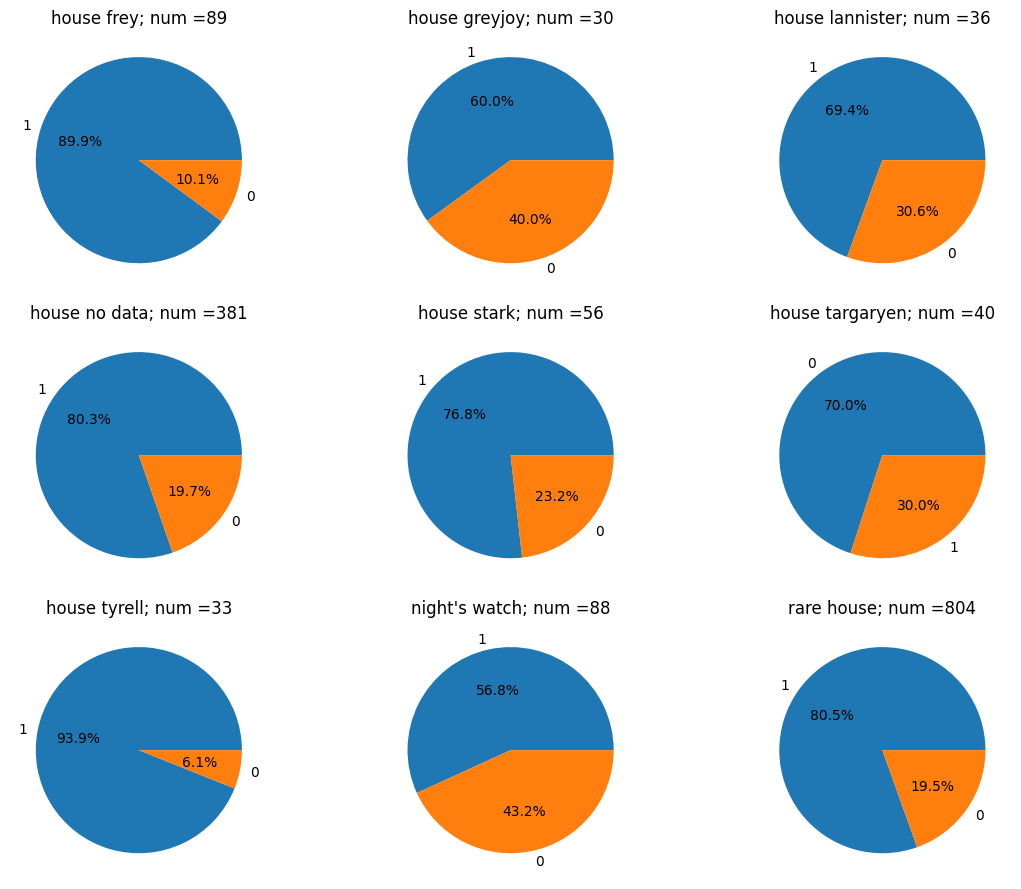

In [409]:
plt.figure(figsize=(12, 9))

for i, house in enumerate(sorted(data['house'].unique())):
    temp = data.loc[data['house'] == house, 'isAlive'].value_counts().reset_index()
    plt.subplot(3, 3, i + 1)
    plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
    plt.title(f"{house}; num ={sum(temp['count'])}")

plt.tight_layout()
plt.show()

Корреляция, как видно из графиков (да и по логике), есть, признак, как мне кажется важный.

### Категориальный признак spouse

In [410]:
data['spouse'].isna().sum()

np.int64(1357)

В данном столбце очень много признаков и уникальных значений, поэтому нужно сделать следующее:
1) заполнить пропуски;
2) привести признак к значениям есть супруг/супруга или нет.

Заполним пропуски.

In [411]:
def fill_missing_spouse(name: str) -> str:
    if pd.notna(name):
        if name in data['spouse']:
            return data.loc[data['spouse'] == name, 'name'] if data.loc[data['spouse'] == name, 'name'].notna() else "spouse no data"
        else:
            return "spouse no data"
    else:
        return "spouse no data"

In [412]:
data.loc[data['spouse'].isna(), 'spouse'] = data.loc[data['spouse'].isna(), 'spouse'].apply(fill_missing_spouse)

Сократим категории.

In [413]:
data.loc[data['spouse'] != 'spouse no data', 'spouse'] = 'have spouse'

Теперь посмотрим на корреляцию с целевой переменной.

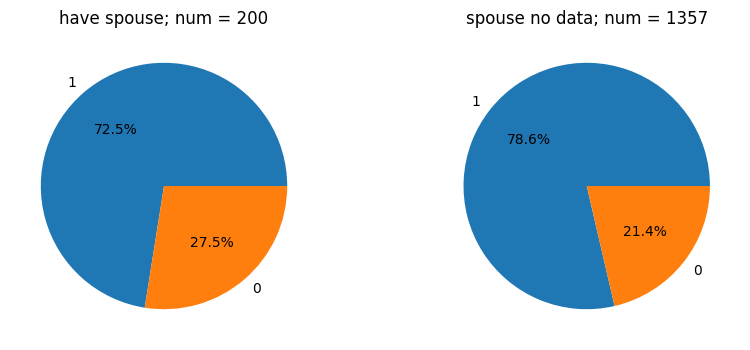

In [414]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
temp = data.loc[data['spouse'] == 'have spouse', 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'have spouse; num = {sum(temp['count'])}')

plt.subplot(1, 2, 2)
temp = data.loc[data['spouse'] == 'spouse no data', 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'spouse no data; num = {sum(temp['count'])}')

plt.show()

Тут я бы сказал, что какой-то сильной корреляции тут нет и, возможно, стоит потом удалить данный столбец.

Переименуем признак для большей наглядности.

In [415]:
d1 = data.copy(deep=True)
data = data.rename(columns={'spouse': 'have spouse data'})

### Категориальные признаки book1, book2, book3, book4, book5

В данных признаках всё хорошо, так что сразу перейдём к оценке корреляции с целевой переменной.

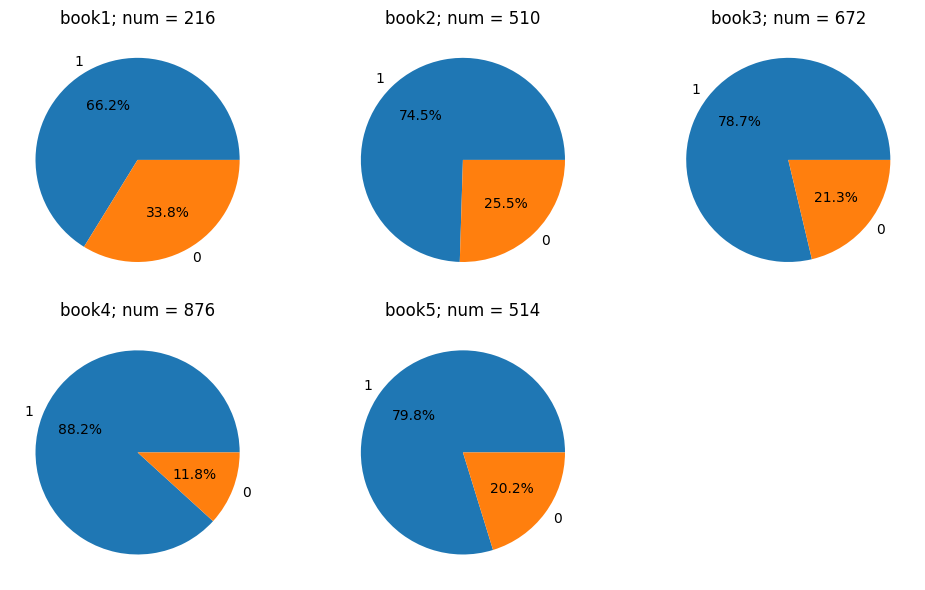

In [416]:
plt.figure(figsize=(10, 6))

for i, book in enumerate(['book1', 'book2', 'book3', 'book4', 'book5']):
    plt.subplot(2, 3, i + 1)
    temp = data.loc[data[book] == 1, 'isAlive'].value_counts().reset_index()
    plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
    plt.title(f"{book}; num = {sum(temp['count'])}")

plt.tight_layout()
plt.show()

По моему корреляция есть, стоит оставить каждый из этих признаков.

### Категориальный признак isAliveMother

В этом признаке огромное количество пропусков, кроме того нет никакой возможности заполнить их, поэтому данный признак стоит удалить.

### Категориальный признак isAliveFather

В этом признаке огромное количество пропусков, кроме того нет никакой возможности заполнить их, поэтому данный признак стоит удалить.

### Категориальный признак isAliveHeir

В этом признаке огромное количество пропусков, кроме того нет никакой возможности заполнить их, поэтому данный признак стоит удалить.

### Категориальный признак isAliveSpouse

В этом признаке огромное количество пропусков, кроме того нет никакой возможности заполнить их, поэтому данный признак стоит удалить.

### Категориальный признак isMarried

Данный признак, по логике, должен быть равнозначен столбцу spouse, поэтому один из них стоит удалить, скорее всего, данный признак.

### Порядковый признак isNoble

In [417]:
data['isNoble'].value_counts(dropna=False)

,count
isNoble,
0,873
1,684


С данным признаком всё хорошо, тогда сразу перейдём к оценке корредяции.

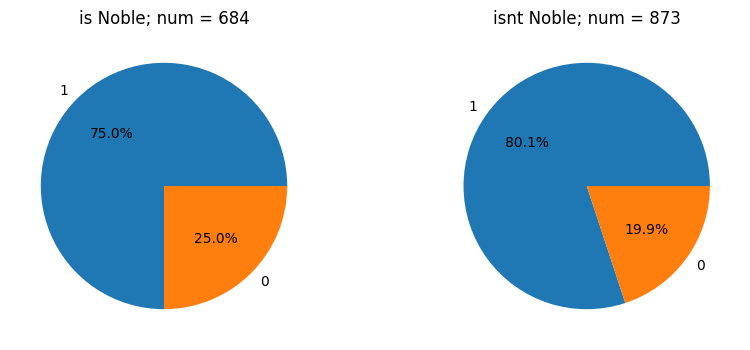

In [418]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
temp = data.loc[data['isNoble'] == 1, 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'is Noble; num = {sum(temp['count'])}')

plt.subplot(1, 2, 2)
temp = data.loc[data['isNoble'] == 0, 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f'isnt Noble; num = {sum(temp['count'])}')

plt.show()

Какой-то сильной корреляции нет, но я бы не стал сейчас удалять данный признак.

### Количественный признак age

В данном признаке огромное количество пропусков, которые нельзя заполнить исходя из остальных признаков, поэтому стоит удалить данный признак.

### Количественный признак numDeadRetarions

In [419]:
data['numDeadRelations'].value_counts()

,count
numDeadRelations,
0,1488
1,24
5,10
7,7
4,7
3,4
10,4
2,4
6,3


Видно, что все значения больше 1 представлены очень маленьким количеством человек, поэтому данный признак стоит привести к категориальному типу: есть связи с умершими персонажами или нет.

In [420]:
def transform_numDeadRelations(numDeadRelations: int) -> int:
    return numDeadRelations if numDeadRelations == 0 else 1

In [421]:
data['numDeadRelations'] = data['numDeadRelations'].apply(transform_numDeadRelations)
data = data.rename(columns={'numDeadRelations' : 'haveDeadRelations'})

Теперь посмотрим на корреляцию с целевой переменной.

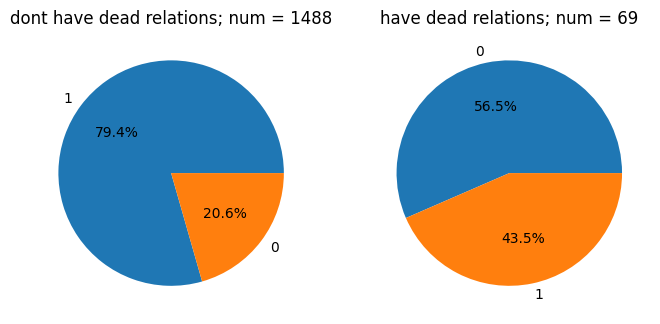

In [422]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
temp = data.loc[data['haveDeadRelations'] == 0, 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f"dont have dead relations; num = {sum(temp['count'])}")

plt.subplot(1, 2, 2)
temp = data.loc[data['haveDeadRelations'] == 1, 'isAlive'].value_counts().reset_index()
plt.pie(temp['count'], labels=temp['isAlive'], autopct='%1.1f%%')
plt.title(f"have dead relations; num = {sum(temp['count'])}")

plt.show()

Есть явная корреляция, правда класс с высокой корреляцией имеет мало представителей.

### Количественный признак popularity

In [423]:
data['popularity'] = np.log10(data['popularity']*200+1)

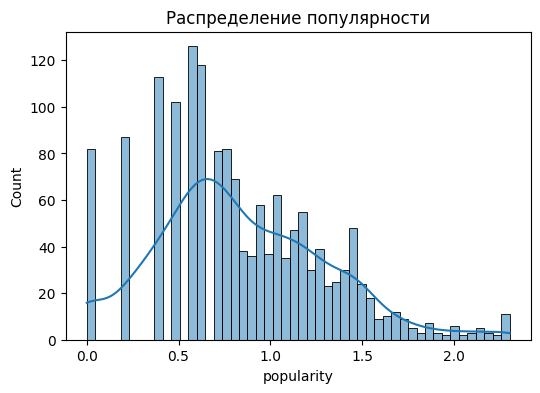

In [424]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='popularity', kde=True, bins=50)
plt.title('Распределение популярности')
plt.show()

Посмотрим на корреляцию с целевой переменной.

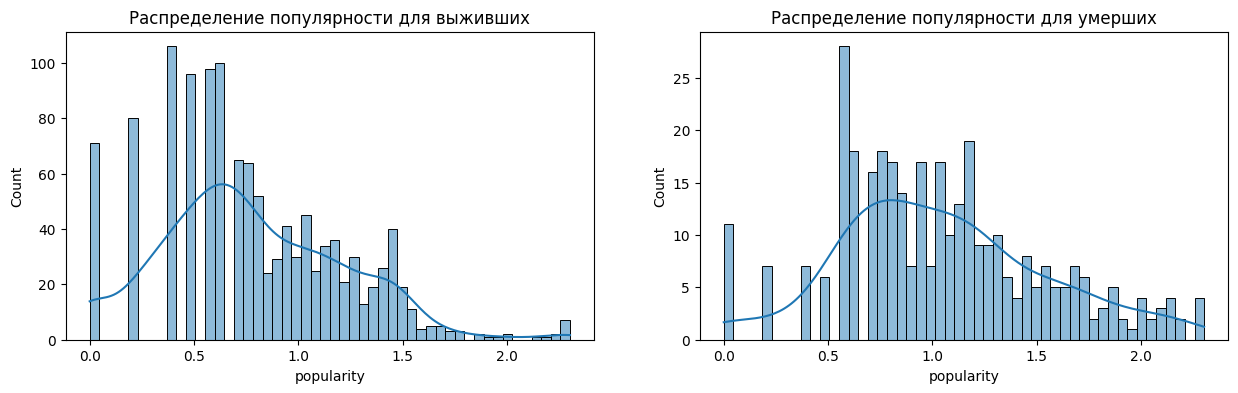

In [425]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=data[data['isAlive'] == 1], x='popularity', kde=True, bins=50)
plt.title('Распределение популярности для выживших')

plt.subplot(1, 2, 2)
sns.histplot(data=data[data['isAlive'] == 0], x='popularity', kde=True, bins=50)
plt.title('Распределение популярности для умерших')

plt.show()

Видно, что среди выживших распределение популярности смещено к левому краю, а для умерших - к правому. Таким образом, корреляция есть и она заметна.

## Итоги EDA

Подведём итог проделанного EDA:

Значимыми столбцами являются:
- title
- male
- culture
- house
- book1
- book2
- book3
- book4
- book5
- isNoble
- numDeadRelations
- popularuty

Точно удаляемые столбцы:
- name
- dateOfBirth
- mother
- father
- isAliveMother
- isAliveFather
- isAliveHeir
- isAliveSpouse
- isMarried
- age

Кандидаты на удаление (малозначимые признаки):
- have heir data
- have spouse data

Данный признаки пока не будем удалять, сначала стоит обучить логистическую регрессию с L1 регуляризацией и посмотреть на веса у этих признаков. Если они будут близки к 0, то их стоит удалить.

## Кодирование категориальных признаков и обработка пропусков

Сами категориальный признаки уже предобработаны, осталось только для некоторых из них сделать OHE.

Что касается пропусков, то стоит подумать стоит ли добавлять столбец для неизвестных категорий и для пропущенных категорий.

### Обработка пропусков и неизвестных значений

**Категориальный признак name:**

Для данного признака стоит просто заменять пропуск на пустую строку. Никаких дополнительных столбцов не нужно.

**Порядковый признак title:**

Тут тоже ничего не стоит менять и просто присваивать 0 неизвестным или пропущенным значениям.

**Категориальный признак male:**

Стоит добавить признак male no data. Так как пропуск не значит, что это мужчина или женщина.

In [426]:
data['male no data'] = np.zeros(shape=(data.shape[0], ), dtype=int)

**Категориальный признак culture:**

Тут всё предусмотрено, так что ничего делать не надо.

**Категориальный признак have heir data:**

Тут ничего делать не стоит, пропускам присваиваеим 0, в противном случае 1.

**Категориальный признак house:**

Тут нужно добавить признак для неизвестных домов.

In [427]:
data['other house'] = np.zeros(shape=(data.shape[0], ), dtype=int)

**Категориальный признак have spouse data:**

Тут всё аналогично признаку have heir data.

**Категориальные признаки book1, book2, book3, book4, book4:**

Тут тоже всё хорошо, пропускам присваиваем 0 и всё.

**Категориальный признак isNoble:**

Тут стоит добавить столбец для пропусков isNoble no data.

In [428]:
data['isNoble no data'] = np.zeros(shape=(data.shape[0], ))

**Категориальный признак haveDeadRelations:**

Тут стоит добавить новый признак deadRelations no data.

In [429]:
data['deadRelations no data'] = np.zeros(shape=(data.shape[0], ))

**Количественный признак popularity:**

Тут не стоит плодить признаки, а пропуски просто заполнять значением -1.

### Обработка категориальных признаков

**Категориальный признак culture**

In [430]:
ohe_culture = pd.get_dummies(data['culture'], drop_first=False)
data = pd.concat([data, ohe_culture], axis=1)
data.drop(columns='culture', inplace=True)

**Категориальный признак have heir data**

In [431]:
data['have heir data'] = data['have heir data'].apply(lambda x: 1 if x == 'have heir' else 0)

**Категориальный признак house**

In [432]:
ohe_house = pd.get_dummies(data['house'], drop_first=False)
data = pd.concat([data, ohe_house], axis=1)
data.drop(columns='house', inplace=True)

**Категориальный признак have spouse data**

In [433]:
data['have spouse data'] = data['have spouse data'].apply(lambda x: 1 if x == 'have spouse' else 0)

### Удаление ненужных столбцов

In [434]:
data.drop(columns=['name', 'dateOfBirth', 'mother', 'father', 'isAliveFather', 'isAliveMother', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'age'], inplace=True)

## Отбор признаков

Как было сказано ранее нужно решить судьбу признаков have heir data и have spouse data. Делать это будем по результатам логистической регрессии с L1 регуляризацией.

Обучаем логистическую регрессию.

In [435]:
X = data.drop(columns='isAlive')
y = data['isAlive']

model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42)
model.fit(X, y)

weights_df = pd.DataFrame({
    'Feature': X.columns,
    'Weight': model.coef_[0]
})

print("Веса по столбцам:")
print(weights_df.sort_values('Weight', key=abs, ascending=False))

Веса по столбцам:
                      Feature    Weight
7                       book4  1.822429
11                 popularity -1.693771
34               house tyrell  1.657979
29              house greyjoy -1.181710
35              night's watch -0.989648
28                 house frey  0.864192
17                      dorne  0.859246
32                house stark  0.801378
20              other nations -0.699047
19                old nations -0.687027
21           the iron islands  0.614437
33            house targaryen -0.517142
31              house no data  0.401935
4                       book1 -0.396303
1                        male -0.337720
23  the mountain and the vale  0.300136
24                  the north  0.223717
10          haveDeadRelations -0.219056
36                 rare house  0.167315
5                       book2 -0.162674
8                       book5  0.097206
26                   the rock -0.086797
0                       title -0.027768
3            have spou

По значениям весов видно, что have heir data никакого значения не несё, а spouse какое-то да имеет. Следовательно heir удалим, а spouse оставим.

In [436]:
data = data.drop(columns='have heir data')

## Подготовка тестовых данных

На протяжении прошлых разделов мы выяснили как данные нужно готовить: как обрабатывать признаки, какие признаки удалять и так далее. Теперь пришло время написать (для удобства) функцию, которая по одному нажатию мыши будет подготовливать нам новые данные.

Здесь запишим какие должны быть столбцы

In [437]:
all_columns = list(data.drop(columns='isAlive').columns)
culture_columns = list(ohe_culture.columns)
house_columns = list(ohe_house.columns) + ['other house']

### Сюда вынесем функции, которые мы написали для обработки

#### title

In [438]:
# title
title_values = [
    'King', 'Queen', 'Prince', 'Princess', 'Lord', 'Lady', 'Ser', 'Maester',
    'Archmaester', 'Grand Maester', 'Hand', 'Castellan', 'Seneschal', 'Steward',
    'Captain', 'Commander', 'Lord Commander', 'Master', 'Knight', 'Septon', 'Septa',
    'Goodwife', 'Goodman', 'Wisdom', 'Khal', 'Khalakka', 'Bloodrider',
    'Protector', 'Dowager', 'Regent', 'Chancellor'
]
def fill_missing_titles(name: str) -> str:
    if pd.notna(name):
        for title in title_values:
            if title in name:
                return title
        else:
            return "title no data"
    else:
        "title no data"

title_hierarchy = {
    # Уровень 10 - Верховная власть
    'king': 10, 'queen': 10, 'prince': 10, 'princess': 10,
    'king in the north': 10, 'king-beyond-the-wall': 10,
    'lord paramount of the mander': 10, 'lord paramount of the trident': 10,
    'prince of dorne': 10, 'prince of dragonstone': 10,
    'hand of the king': 10, 'protector of the realm': 10,

    # Уровень 9 - Высшая знать
    'lord': 9, 'lady': 9, 'lord of': 9, 'lady of': 9,
    'lord commander': 9, 'lord reaper of pyke': 9,
    'lord of the iron islands': 9, 'lord of the crossing': 9,
    'lord of the tides': 9, 'lord of the marches': 9,

    # Уровень 8 - Старшая знать
    'castellan': 8, 'master': 8, 'seneschal': 8, 'high steward': 8,
    'lord steward': 8, 'master of': 8, 'lord seneschal': 8,

    # Уровень 7 - Рыцарство и командиры
    'ser': 7, 'commander': 7, 'captain': 7, 'knight': 7,
    'first sword': 7, 'first ranger': 7,

    # Уровень 6 - Религиозные лидеры
    'archmaester': 6, 'grand maester': 6, 'septa': 6, 'septon': 6,
    'red priest': 6, 'blue grace': 6,

    # Уровень 5 - Специалисты
    'maester': 5, 'wisdom': 5, 'steward': 5, 'magister': 5,

    # Уровень 4 - Воины и всадники
    'bloodrider': 4, 'khal': 4, 'khalakka': 4, 'warrior': 4,

    # Уровень 3 - Младшие должности
    'cupbearer': 3, 'brother': 3, 'goodman': 3, 'goodwife': 3,
    'proctor': 3,

    # Уровень 2 - Простые титулы
    'good master': 2, 'tradesman': 2,

    # Уровень 1 - Неопределенные
    'winterfell': 1, 'casterly rock': 1, 'highgarden': 1,
    'rain house': 1, 'eyrie': 1, 'dragonstone': 1,
    'seven kingdoms': 1, 'greenstone': 1, 'stokeworth': 1,
    'hornwood': 1, 'coldmoat': 1, 'last hearth': 1,
    'seagard': 1, 'uplands': 1, 'ashford': 1, 'bitterbridge': 1,
    'whitewalls': 1, 'claw isle': 1, 'ironoaks': 1,
    'goldengrove': 1, 'redfort': 1, 'harridan hill': 1,
    'longbow hall': 1, 'hayford': 1, 'skyreach': 1,
    'feastfires': 1, 'sweetsister': 1, 'starpike': 1,
    'sweetport sound': 1, 'stonehelm': 1, 'greyshield': 1,
    'felwood': 1, 'goldgrass': 1, 'tower of glimmering': 1,
    'big bucket': 1, 'honeyholt': 1, 'runestone': 1,
    'duskendale': 1, 'grassy vale': 1, 'dyre den': 1,
    'sunflower hall': 1, 'pinkmaiden': 1, 'cerwyn': 1,
    'snakewood': 1, 'flint\'s finger': 1, 'longsister': 1,
    'coldwater burn': 1, 'fair isle': 1, 'deepwood motte': 1,
    'acorn hall': 1, 'ten towers': 1, 'saltpans': 1,
    'sealskin point': 1, 'three sisters': 1, 'grey glen': 1,
    'iron holt': 1, 'maidenpool': 1, 'starfall': 1,
    'nightsong': 1, 'eastwatch-by-the-sea': 1,
    'red flower vale': 1, 'hellholt': 1, 'crakehall': 1,
    'the liddle': 1, 'salt shore': 1, 'tally hill': 1,
    'king\'s landing': 1, 'crag': 1, 'volmark': 1,
    'rook\'s rest': 1, 'oldcastle': 1, 'southshield': 1,
    'sandstone': 1, 'wyndhall': 1, 'knight of': 1,
    'lord of atranta': 1, 'lord of oldtown': 1,
    'lord of pebbleton': 1, 'lord of the red dunes': 1,
    'lord of the snakewood': 1, 'lord of the tor': 1,

    # Уровень 0 - Неизвестные и специальные случаи
    'title no data': 0, 'light of the west': 1, 'mistress of whisperers': 1,
    'master of ships': 1, 'master of coin': 1, 'foamdrinker': 1,
    'king of astapor': 10, 'greenstone': 1, 'wind witch': 1,
    'chief undergaoler': 3, 'undergaoler': 3, 'oarmaster': 3,
    'master-at-arms': 3, 'the wull': 2, 'red hand': 2,
    'widow\'s watch': 1, 'castle lychester': 1, 'heart\'s home': 1,
    'godsgrace': 1, 'karl\'s hold': 1, 'blackmont': 1,
    'golden tooth': 1, 'crows nest': 1, 'deep den': 1,
    'sharp point': 1, 'cobblecat': 1, 'three towers': 1,
    'ghost hill': 1, 'shatterstone': 1, 'lordsport': 1,
    'blackcrown': 1, 'strongsong': 1, 'brightwater': 1,
    'broad arch': 1, 'lady marya': 1, 'golden tooth': 1,
    'harrenhal': 1, 'karhold': 1, 'riverrun': 1,
    'king of the andals': 10, 'king of the iron islands': 10,
    'black bride': 1, 'princessqueen': 10, 'queendowager queen': 10,
    'princesssepta': 6, 'lord commander of the night\'s watch': 9
}
def ranking_of_titles(title: str) -> int:
    return title_hierarchy[title] if title in title_hierarchy else 0

#### culture

In [439]:
cultures_grouped = {
    'old nations': ['valyrian', 'first men', 'andal', 'andals', 'rhoynar'],
    'the north': ['northmen', 'northern mountain clans', 'crannogmen'],
    'the iron islands': ['ironborn', 'ironborn', 'ironmen'],
    'the mountain and the vale': ['valemen', 'vale', 'vale mountain clans', 'sistermen'],
    'the isles and rivers': ['riverlands', 'rivermen'],
    'the rock': ['westerman', 'westermen', 'westerlands'],
    'the stormlands': ['stormlander', 'stormlands'],
    'the reach': ['reach', 'reachmen', 'the reach'],
    'dorne': ['dornish', 'dornishmen', 'dorne'],
    'essos nations': ['astapor', 'astapori', 'braavosi', 'braavos', 'tyroshi', 'lysene', 'lyseni',
                    'myrish', 'pentoshi', 'qartheen', 'qarth', 'dothraki',
                    'lhazarene', 'lhazareen', 'meereen', 'meereenese',
                    'norvoshi', 'qohor', 'summer isles', 'summer islands',
                    'summer islander', 'asshai', "asshai'i", 'norvos', 'ghiscari',
                    'ghiscaricari'],
    'other nations': ['ibbenese', 'westeros', 'free folk', 'wildling', 'wildlings', 'naathi']
}

cultures_grouped_inverted = {}
for k in cultures_grouped.keys():
  for v in cultures_grouped[k]:
      cultures_grouped_inverted.update({v:k})

def group_culture(culture: str) -> str:
    return cultures_grouped_inverted[culture] if culture in cultures_grouped_inverted else "other nations"

def fill_missing_culture(row):
    father = row['father']
    mother = row['mother']

    if pd.notna(father) and father in d2['name'].values:
        father_culture = d2.loc[data['name'] == father, 'culture']
        if not father_culture.empty and pd.notna(father_culture.iloc[0]):
            return father_culture.iloc[0]

    if pd.notna(mother) and mother in d2['name'].values:
        mother_culture = d2.loc[d2['name'] == mother, 'culture']
        if not mother_culture.empty and pd.notna(mother_culture.iloc[0]):
            return mother_culture.iloc[0]

    return "culture no data"

#### house

In [440]:
house_mapping = {
    # Основные великие дома
    'targaryen': 'House Targaryen', 'stark': 'House Stark',
    'lannister': 'House Lannister', 'baratheon': 'House Baratheon',
    'greyjoy': 'House Greyjoy', 'tyrell': 'House Tyrell',
    'martell': 'House Martell', 'arryn': 'House Arryn',
    'tully': 'House Tully', 'frey': 'House Frey',
    'bolton': 'House Bolton', 'mormont': 'House Mormont',
    'tarly': 'House Tarly', 'reed': 'House Reed',
    'glover': 'House Glover', 'umber': 'House Umber',
    'karstark': 'House Karstark', 'manderly': 'House Manderly',
    'cerwyn': 'House Cerwyn', 'hightower': 'House Hightower',
    'redwyne': 'House Redwyne', 'florent': 'House Florent',
    'harlaw': 'House Harlaw', 'goodbrother': 'House Goodbrother',
    'botley': 'House Botley', 'blacktyde': 'House Blacktyde',
    'drumm': 'House Drumm', 'farwynd': 'House Farwynd',
    'volmark': 'House Volmark', 'wull': 'House Wull',
    'dayne': 'House Dayne', 'yronwood': 'House Yronwood',
    'fowler': 'House Fowler', 'blackwood': 'House Blackwood',
    'bracken': 'House Bracken', 'mallister': 'House Mallister',
    'marbrand': 'House Marbrand', 'crakehall': 'House Crakehall',
    'lefford': 'House Lefford', 'brax': 'House Brax',
    'prester': 'House Prester', 'swyft': 'House Swyft',
    'serrett': 'House Serrett', 'bane': 'House Bane',

    # Другие значимые дома
    'osgrey': 'House Osgrey', 'webber': 'House Webber',
    'costayne': 'House Costayne', 'peake': 'House Peake',
    'ball': 'House Ball', 'caron': 'House Caron',
    'dondarrion': 'House Dondarrion', 'swann': 'House Swann',
    'tarth': 'House Tarth', 'selmy': 'House Selmy',
    'estermont': 'House Estermont', 'velaryon': 'House Velaryon',
    'celtigar': 'House Celtigar', 'santagar': 'House Santagar',
    'allyrion': 'House Allyrion', 'vaith': 'House Vaith',
    'manwoody': 'House Manwoody', 'qorgyle': 'House Qorgyle',
    'jor': 'House Jordayne', 'toland': 'House Toland',
    'blackmont': 'House Blackmont', 'fowler': 'House Fowler',
    'gargalen': 'House Gargalen', 'uller': 'House Uller',
    'wells': 'House Wells', 'stokeworth': 'House Stokeworth',
    'rosby': 'House Rosby', 'rykker': 'House Rykker',
    'thorne': 'House Thorne', 'paege': 'House Paeg',
    'piper': 'House Piper', 'vance': 'House Vance',
    'smallwood': 'House Smallwood', 'mooton': 'House Mooton',
    'dar': 'House Darry', 'ryger': 'House Ryger',
    'goodbrook': 'House Goodbrook', 'lychester': 'House Lychester',
    'hawick': 'House Hawick', 'whent': 'House Whent',
    'strong': 'House Strong', 'lothston': 'House Lothston',
    'harrenhal': 'House Harrenhal',

    # Организации и группы
    "night's watch": "Night's Watch", 'brotherhood without banners': 'Brotherhood Without Banners',
    'kingsguard': 'Kingsguard', 'faith of the seven': 'Faith of the Seven',
    'maester': 'Maesters', 'alchemists': "Alchemists' Guild",
    'faceless men': 'Faceless Men', 'brave companions': 'Brave Companions',
    'golden company': 'Golden Company', 'stormcrows': 'Stormcrows',
    'second sons': 'Second Sons', 'windblown': 'Windblown',
    'company of the cat': 'Company of the Cat', 'burned men': 'Burned Men',
    'stone crows': 'Stone Crows', 'moon brothers': 'Moon Brothers',
    'black ears': 'Black Ears', 'kingswood brotherhood': 'Kingswood Brotherhood',
    'drowned men': 'Drowned Men', 'ironborn': 'Ironborn',
    'wildling': 'Wildling', 'free folk': 'Wildling'
}
def fill_missing_house(name: str) -> str:
    if pd.notna(name):
        for peace in name.split(' '):
            if peace in house_mapping:
                return house_mapping[peace]
        else:
            return 'other house'
    else:
        return "house no data"

#### spouse

In [441]:
def fill_missing_spouse(name: str) -> str:
    if pd.notna(name):
        if name in d1['spouse']:
            return d1.loc[d['spouse'] == name, 'name'] if d1.loc[data['spouse'] == name, 'name'].notna() else "spouse no data"
        else:
            return "spouse no data"
    else:
        return "spouse no data"

### Общая функция обработки

In [442]:
def data_prepare_row(row: pd.Series) -> pd.Series:
    res = pd.Series(index=all_columns)
    # обработка name
    if pd.isna(row.loc['name']):
        row.loc['name'] = ""

    # обработка title
    if pd.isna(row.loc['title']):
        row.loc['title'] = fill_missing_titles(row['title'])
    res.loc['title'] = ranking_of_titles(row['title'])

    # обработка male
    if pd.isna(row.loc['male']):
        res.loc['male'] = 0
        res.loc['male no data'] = 1
    else:
        res.loc['male'] = row.loc['male']
        res.loc['male no data'] = 0

    # обработка culture
    if pd.isna(row.loc['culture']):
        row.loc['culture'] = fill_missing_culture(row)
    culture = group_culture(row.loc['culture'])
    res.loc[culture] = 1
    culture_columns_ = culture_columns.copy()
    culture_columns_.remove(culture)
    res.loc[culture_columns_] = np.zeros(shape=(len(culture_columns_),))

    # обработка dataOfBirth
    # (ничего не делаем)

    # обработка mother
    # (ничего не делаем)

    # обработка father
    # (ничего не делаем)

    # обработка heir
    # (ничего не делаем)

    # обработка house
    row.loc['house'] = fill_missing_house(row.loc['name'])
    res.loc[row.loc['house']] = 1
    house_columns_ = house_columns.copy()
    house_columns_.remove(row.loc['house'])
    res.loc[house_columns_] = np.zeros(shape=(len(house_columns_), ))

    # обработка spouse
    if pd.isna(row.loc['spouse']):
        row.loc['spouse'] = fill_missing_spouse(row.loc['name'])
    res.loc['have spouse data'] = 0 if pd.isna(row.loc['spouse']) else 1

    # обработка book1, book2, book3, book4, book5
    res.loc['book1'] = row.loc['book1'] if pd.isna(row.loc['book1']) else 0
    res.loc['book2'] = row.loc['book2'] if pd.isna(row.loc['book2']) else 0
    res.loc['book3'] = row.loc['book3'] if pd.isna(row.loc['book3']) else 0
    res.loc['book4'] = row.loc['book4'] if pd.isna(row.loc['book4']) else 0
    res.loc['book5'] = row.loc['book5'] if pd.isna(row.loc['book5']) else 0

    # обработка isAliveMother
    # (ничего не делаем)

    # обработка isAliveFather
    # (ничего не делаем)

    # обработка isAliveHeir
    # (ничего не делаем)

    # обработка isAliveSpouse
    # (ничего не делаем)

    # обработка isAliveMarried
    # (ничего не делаем)

    # обработка isNoble
    res.loc['isNoble'] = row.loc['isNoble'] if pd.isna(row.loc['isNoble']) else 0
    res.loc['isNoble no data'] = 1 if pd.isna(row.loc['isNoble']) else 0

    # обработка age
    # (ничего не делаем)

    # обработка numDeadRelations
    res.loc['haveDeadRelations'] = 0 if pd.isna(row.loc['numDeadRelations']) else 1 if row.loc['numDeadRelations'] > 0 else 0
    res.loc['deadRelations no data'] = 1 if pd.isna(row.loc['numDeadRelations']) else 0

    # обработка popularity
    res.loc['popularity'] = -1 if pd.isna(row.loc['popularity']) else np.log10(row.loc['popularity']*100+2)

    return res

In [443]:
def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    res_data = pd.DataFrame(columns=all_columns)

    for index_row in range(data.shape[0]):
        print("____________________________________")
        print(data.iloc[index_row, :])
        print("____________________________________")
        res_data.loc[ len(res_data.index) ] = data_prepare_row(data.iloc[index_row, :])

    return res_data

### Подготовка тестовых данных

In [444]:
%%capture
train_data = data.copy(deep=True)
test_data = prepare_data(pd.read_csv('game_of_thrones_test.csv'))

## Обучение моделей

In [445]:
X = train_data.drop(columns='isAlive')
y = train_data['isAlive']

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [447]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

test_data = scaler.transform(test_data)

**Теперь обучим и подберём гиперпараметры для логистической регресии.**

In [448]:
logreg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.001, 1.0, 0.01),
    'max_iter': [50, 100, 200, 300, 400],
    'solver': ['liblinear']
}

sk_logreg = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_logreg.fit(X_train, y_train)
sk_logreg.best_params_

{'C': np.float64(0.030999999999999996),
 'max_iter': 50,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [449]:
my_logreg = LogisticRegressionBinaryClassifier()
my_logreg.fit(X=X_train, y=y_train, learning_rate=0.03, reg='l2', reg_rate=0.0001, max_iter=50, batch_size=200)

Качество

In [450]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_logreg.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_logreg.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_logreg.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_logreg.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_logreg.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_logreg.predict(X_test))}')
print("____________________________________________")

print('Качество на обучении для моей реализации')
print(f'accuracy = {accuracy_score(y_train, my_logreg.predict(X_train))}')
print(f'precision = {precision_score(y_train, my_logreg.predict(X_train))}')
print(f'recall = {recall_score(y_train, my_logreg.predict(X_train))}')
print()
print('Качество на тесте для моей реализации')
print(f'accuracy = {accuracy_score(y_test, my_logreg.predict(X_test))}')
print(f'precision = {precision_score(y_test, my_logreg.predict(X_test))}')
print(f'recall = {recall_score(y_test, my_logreg.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8192771084337349
precision = 0.8333333333333334
recall = 0.962128966223132

Качество на тесте для sklearn реализации
accuracy = 0.7948717948717948
precision = 0.8
recall = 0.9702127659574468
____________________________________________
Качество на обучении для моей реализации
accuracy = 0.7799196787148595


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Не понимаю в чём тут проблема, если често. Всё правильно реализовано, задача тут бинарной классификации, почему он говорит про многоклассовую я не знаю.

**Теперь обучим и подберём гиперпараметры KNN**

In [451]:
sk_knn_params = {
    'n_neighbors': [4, 6, 10],
    'metric': ['manhattan', 'euclidean']
}

sk_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=sk_knn_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_knn.fit(X_train, y_train)
sk_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 10}

In [452]:
my_knn = KNNClassifier(number_of_neighbors=10)
my_knn.fit(X=X_train, y=y_train)

Качество

In [453]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_knn.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_knn.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_knn.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_knn.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_knn.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_knn.predict(X_test))}')
print("____________________________________________")

print('Качество на обучении для моей реализации')
print(f'accuracy = {accuracy_score(y_train, my_knn.predict(X_train))}')
print(f'precision = {precision_score(y_train, my_knn.predict(X_train))}')
print(f'recall = {recall_score(y_train, my_knn.predict(X_train))}')
print()
print('Качество на тесте для моей реализации')
print(f'accuracy = {accuracy_score(y_test, my_knn.predict(X_test))}')
print(f'precision = {precision_score(y_test, my_knn.predict(X_test))}')
print(f'recall = {recall_score(y_test, my_knn.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8401606425702811
precision = 0.8575367647058824
recall = 0.95496417604913

Качество на тесте для sklearn реализации
accuracy = 0.8108974358974359
precision = 0.8211678832116789
recall = 0.9574468085106383
____________________________________________
Качество на обучении для моей реализации
accuracy = 0.8433734939759037
precision = 0.8587155963302753
recall = 0.9580348004094166

Качество на тесте для моей реализации
accuracy = 0.8012820512820513
precision = 0.8145454545454546
recall = 0.9531914893617022
____________________________________________


**Теперь обучим и подберём параметры для метода опорных векторов.**

In [454]:
sk_svm_params = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1]
}

sk_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=sk_svm_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_svm.fit(X_train, y_train)
sk_svm.best_params_

{'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'}

Качество

In [455]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_svm.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_svm.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_svm.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_svm.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_svm.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_svm.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8353413654618473
precision = 0.82991452991453
recall = 0.9938587512794268

Качество на тесте для sklearn реализации
accuracy = 0.7724358974358975
precision = 0.7733333333333333
recall = 0.9872340425531915
____________________________________________


**Теперь обучим и подберём гиперпараметры для наивного байесовского классификатора.**

In [456]:
sk_bc_params = {
    'priors': [None, 0.3, 0.7],
    'var_smoothing': [0, 0.5, 1.0, 1.5]
}

sk_bc = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=sk_bc_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_bc.fit(X_train, y_train)
sk_bc.best_params_

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

{'priors': None, 'var_smoothing': 1.5}

Качество

In [457]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_bc.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_bc.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_bc.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_bc.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_bc.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_bc.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.793574297188755
precision = 0.8214285714285714
recall = 0.9416581371545547

Качество на тесте для sklearn реализации
accuracy = 0.7596153846153846
precision = 0.7777777777777778
recall = 0.9531914893617022
____________________________________________


**Теперь обучим и подберём параметры для решающего дерева.**

In [458]:
sk_tree_params = {
    'max_depth': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 10, 16],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

sk_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=sk_tree_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

sk_tree.fit(X_train, y_train)
sk_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Качество

In [459]:
print('Качество на обучении для sklearn реализации')
print(f'accuracy = {accuracy_score(y_train, sk_tree.predict(X_train))}')
print(f'precision = {precision_score(y_train, sk_tree.predict(X_train))}')
print(f'recall = {recall_score(y_train, sk_tree.predict(X_train))}')
print()
print('Качество на тесте для sklearn реализации')
print(f'accuracy = {accuracy_score(y_test, sk_tree.predict(X_test))}')
print(f'precision = {precision_score(y_test, sk_tree.predict(X_test))}')
print(f'recall = {recall_score(y_test, sk_tree.predict(X_test))}')
print("____________________________________________")

Качество на обучении для sklearn реализации
accuracy = 0.8168674698795181
precision = 0.8253692441355344
recall = 0.9723643807574207

Качество на тесте для sklearn реализации
accuracy = 0.7884615384615384
precision = 0.7903780068728522
recall = 0.9787234042553191
____________________________________________


**Теперь построим матрицы ошибок.**

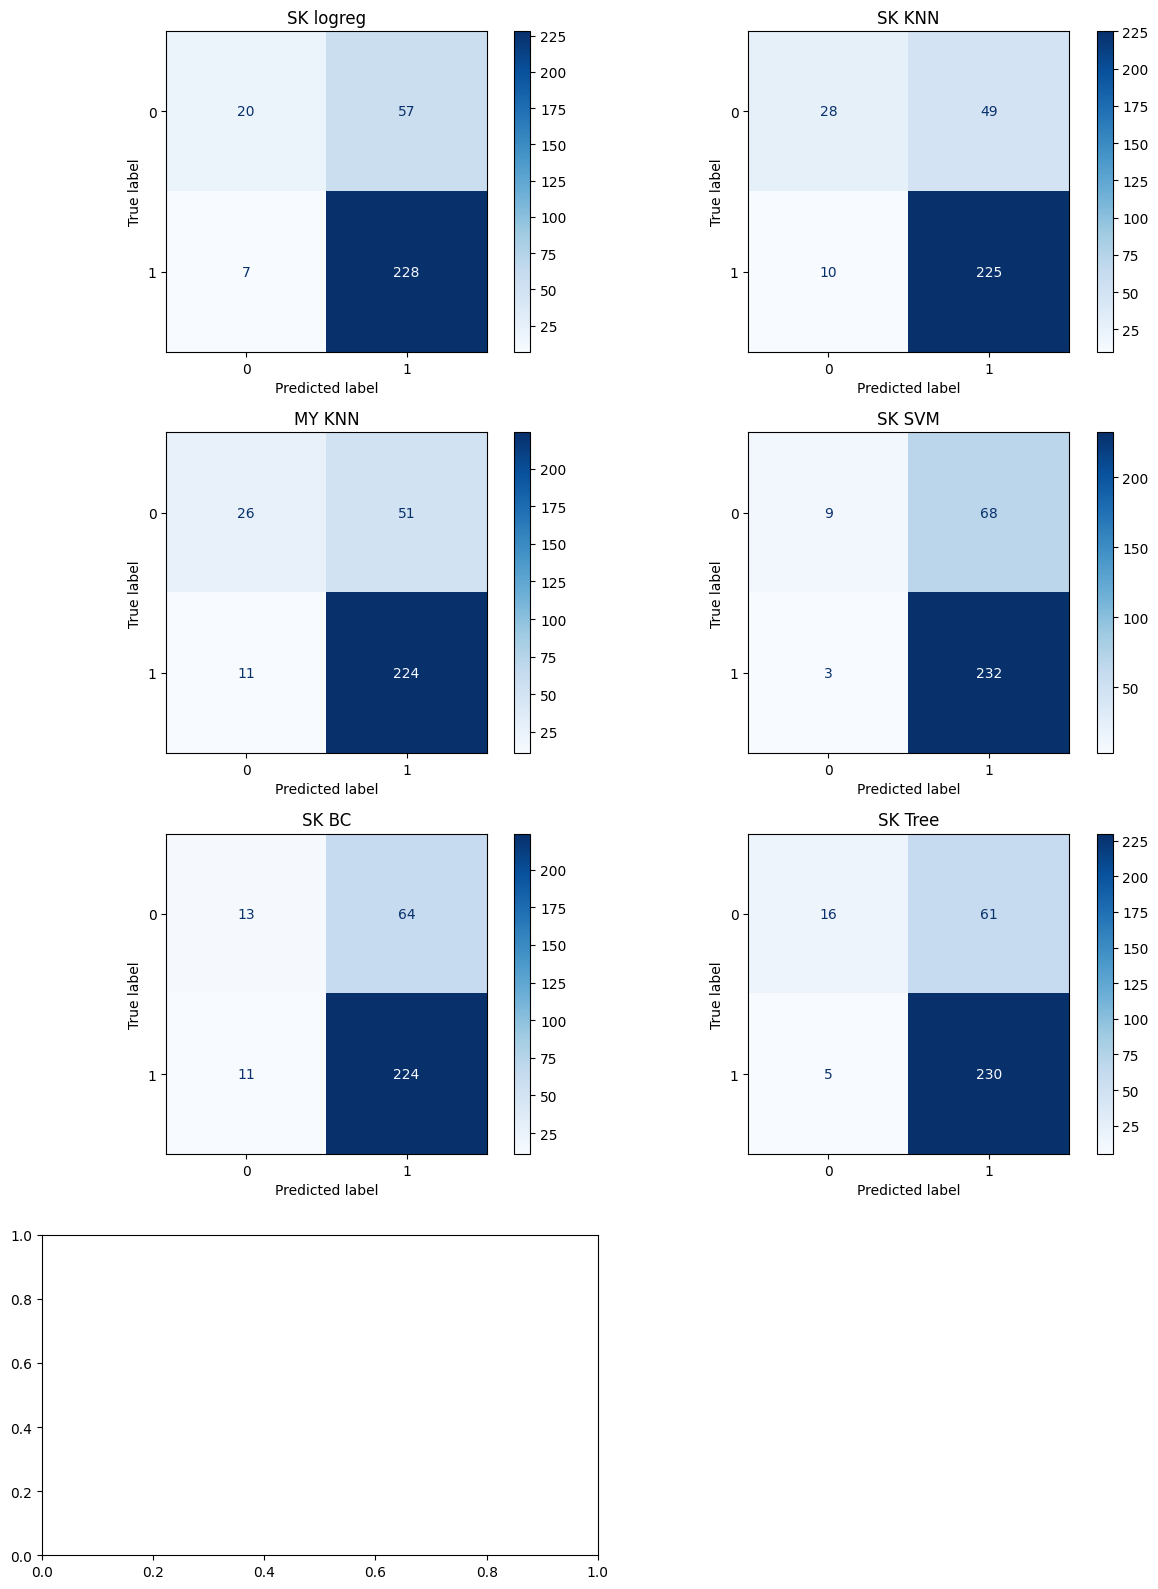

In [463]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.ravel()  # Преобразуем в плоский массив

models = [
    ('SK logreg', sk_logreg),
    #('My logreg', my_logreg),
    ('SK KNN', sk_knn),
    ('MY KNN', my_knn),
    ('SK SVM', sk_svm),
    ('SK BC', sk_bc),
    ('SK Tree', sk_tree)
]

for i, (title, model) in enumerate(models):
    ax = axes[i]
    ax.set_title(title)
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=ax, cmap='Blues')

# Скрываем последнюю пустую subplot если моделей 7, а subplots 8
if len(models) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

В данном случае лучшим был уже KNN, другие модели оказались +- на одном и том же уровне. Сама задача была достаточно сложной, поэтому какого-то высокого качества не получилось.